In [1]:
# UNCOMMENT first with internet option turned on
# Use GPU env

# !pip download tabpfn --no-deps -d pip-packages

# from tabpfn import TabPFNClassifier
# TabPFNClassifier(N_ensemble_configurations = 64, device = 'cuda:0')

# !mv /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt pip-packages/
# !zip -r pip-packages.zip pip-packages

# now you need to download the zip and upload it as dataset with the plus in the top left
# then you need to add it to the notebook as data on the right, and name it `pip-packages-icr`

# now you can turn internet off and still install, like below

In [2]:
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

In [3]:
# !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import datetime
from pyprojroot import here

from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, make_scorer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier
from tabpfn import TabPFNClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, XGBRegressor

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

import warnings
warnings.filterwarnings('ignore')

### Data Pull

In [15]:
# load data
local_dir = str(here()) + '/'
kaggle_dir = '/kaggle/input/'
train_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/greeks.csv')

# join greeks and add Epsilon
train_df.drop(['EJ'], axis = 1, inplace = True)
train_df = pd.merge(train_df, greeks_df, on = 'Id')
train_df = train_df.drop(['Id'], axis = 1)
train_df['Epsilon'] = train_df['Epsilon'].replace('Unknown', np.nan)
train_df_nan = train_df[train_df['Epsilon'].isna()]
train_df = train_df[train_df['Epsilon'].notna()]
train_df['Epsilon'] = pd.to_datetime(train_df['Epsilon'])
train_df['Epsilon'] = train_df['Epsilon'].apply(lambda x: x.toordinal() - 734640)
train_df.reset_index(drop = True, inplace = True)
train_df = pd.concat([train_df, train_df_nan], axis = 0, ignore_index = True)

# Data Pre-Processing

In [16]:
# set random seed
random_seed = 101010
np.random.seed(random_seed)

# create x and y train
X_train = train_df.drop(['Alpha', 'Beta', 'Delta', 'Gamma', 'Class'], axis = 1, inplace = False)
y_train_class = train_df['Class']

y_encoder = LabelEncoder()
y_train_alpha = y_encoder.fit_transform(train_df['Alpha'])
y_train_beta = y_encoder.fit_transform(train_df['Beta'])
y_train_delta = y_encoder.fit_transform(train_df['Delta'])
y_train_gamma = y_encoder.fit_transform(train_df['Gamma'])

In [17]:
# impute data
median_imputer = SimpleImputer(strategy = 'median')
imputed = median_imputer.fit_transform(X_train)
X_train = pd.DataFrame(imputed, columns = X_train.columns, index = X_train.index)

In [18]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

In [19]:
# features tiered by importance
tier_1_features = ['EP', 'CR', 'AY', 'AB', 'DU', 'DA', 'DI', 'DH', 'BC', 'DL', 'EE', 'BQ', 'Epsilon']
tier_2_features = ['EG', 'DY', 'FD ', 'AX', 'FR', 'FC', 'EL', 'DE', 'EU', 'FI', 'CS', 'BN', 'EH', 'EB', 'CC', 'GL', 'FL', 'CU', 'AF']
tier_3_features = ['AH', 'AM', 'AR', 'AZ', 'BD ', 'BP', 'BR', 'BZ', 'CB', 'CD ', 'CF', 'CH', 'CL', 'CW ', 'DF', 'DN', 'DV', 'EJ', 'FE', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI']

# Prediction Features

In [20]:
def model_fit_predict(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    model.fit(X, y)
    model_predictions = model.predict_proba(test)
    predictions_df = pd.DataFrame(model_predictions, columns = model.classes_, index = X_test.index)
    predictions_df.columns = [model_name + '_' + str(col) for col in predictions_df.columns]
    if len(predictions_df.columns) == 2:
        predictions_df = predictions_df[[model_name + '_1']]
    
    return predictions_df

In [21]:
def model_fit_predict_regressor(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    model.fit(X, y)
    model_predictions = model.predict(test)
    predictions_df = pd.DataFrame(model_predictions, columns = ['Anomaly Score'], index = X_test.index)
    predictions_df.columns = [model_name + '_' + str(col) for col in predictions_df.columns]
    if len(predictions_df.columns) == 2:
        predictions_df = predictions_df[[model_name + '_1']]
    
    return predictions_df

In [22]:
def competition_log_loss(y_true, y_pred):
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = np.clip(1 - proba_1, 1e-15, 1 - 1e-15)
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

## Meta Predictions

In [38]:
# models
xgboost_meta = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5, random_state = random_seed)
xtree_meta = ExtraTreesClassifier(criterion = 'log_loss', n_estimators = 250, max_depth = 9, min_samples_split = 3, max_features = 0.5, random_state = random_seed)
tabpfn_meta = TabPFNClassifier(N_ensemble_configurations = 24, seed = random_seed)
guassian_meta = GaussianProcessClassifier(kernel = 1.0 * RBF(1.0), optimizer = 'fmin_l_bfgs_b', n_restarts_optimizer = 0, max_iter_predict = 500, random_state = random_seed)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [39]:
# preprocessors for guassian modeling
scaler = StandardScaler()
transformer = PowerTransformer()
normalizer = Normalizer()

In [40]:
prediction_cols = X_train.columns.to_list()
skf = StratifiedKFold(n_splits = 10, random_state = random_seed, shuffle = True)
meta_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_class[train_index], y_train_class[test_index]
    
    # oversample minority class
    fold, fold_y = ADASYN(random_state = random_seed).fit_resample(fold, fold_y)
    
    # process data for guassian
    scaled_fold = scaler.fit_transform(fold)
    scaled_oof = scaler.transform(oof)
    transformed_fold = transformer.fit_transform(scaled_fold)
    transformed_oof = transformer.transform(scaled_oof)
    normalized_fold = normalizer.fit_transform(transformed_fold)
    normalized_oof = normalizer.transform(transformed_oof)
    guassian_fold = pd.DataFrame(transformed_fold, columns = fold.columns, index = fold.index)
    guassian_oof = pd.DataFrame(transformed_oof, columns = fold.columns, index = oof.index)
    
    # fit and predict
    xgboost_predictions_df = model_fit_predict('XGBoost', xgboost_meta, fold, fold_y, oof, prediction_cols)
    xtree_predictions_df = model_fit_predict('ExtraTrees', xtree_meta, fold, fold_y, oof, prediction_cols)
    tabpfn_predictions_df = model_fit_predict('TabPFN', tabpfn_meta, fold, fold_y, oof, prediction_cols)
    guassian_predictions_df = model_fit_predict('Guassian', guassian_meta, guassian_fold, fold_y, guassian_oof, prediction_cols)
    
    # combine predictions
    predictions_df = pd.concat([xgboost_predictions_df, xtree_predictions_df, tabpfn_predictions_df, guassian_predictions_df], axis = 1)
    meta_df = pd.concat([meta_df, predictions_df])

# add meta features
meta_df.sort_index(inplace = True)
meta_df['Model_Min'] = meta_df.min(axis = 1)
meta_df['Model_Max'] = meta_df.max(axis = 1)
meta_df['Model_Mean'] = meta_df.mean(axis = 1)
meta_df['Model_Range'] = meta_df['Model_Max'] - meta_df['Model_Min']
X_train_meta = pd.concat([X_train, meta_df], axis = 1)

In [120]:
meta_df.sort_index(inplace = True)

meta_df['Model_Min'] = meta_df.min(axis = 1)
meta_df['Model_Max'] = meta_df.max(axis = 1)
meta_df['Model_Mean'] = meta_df.mean(axis = 1)
meta_df['Model_Range'] = meta_df['Model_Max'] - meta_df['Model_Min']

meta_df['XGBoost minus TabPFN'] = meta_df['XGBoost_1'] - meta_df['TabPFN_1']
meta_df['XGBoost minus ExtraTrees'] = meta_df['XGBoost_1'] - meta_df['ExtraTrees_1']
meta_df['XGBoost minus Guassian'] = meta_df['XGBoost_1'] - meta_df['Guassian_1']
meta_df['XGBoost x TabPFN'] = meta_df['XGBoost_1'] * meta_df['TabPFN_1']
meta_df['XGBoost x ExtraTrees'] = meta_df['XGBoost_1'] * meta_df['ExtraTrees_1']
meta_df['XGBoost x Guassian'] = meta_df['XGBoost_1'] * meta_df['Guassian_1']

X_train_meta = pd.concat([X_train, meta_df], axis = 1)

In [42]:
meta_df['Class'] = y_train_class
prediction_cols = ['XGBoost_1', 'ExtraTrees_1', 'TabPFN_1', 'Guassian_1']

roc_auc = []
log_loss = []

for col in prediction_cols:
    print(col)
    print('ROC AUC:', roc_auc_score(meta_df['Class'], meta_df[col]))
    print('Log Loss:', competition_log_loss(meta_df['Class'], meta_df[col]))
    
    roc_auc.append(roc_auc_score(meta_df['Class'], meta_df[col]))
    log_loss.append(competition_log_loss(meta_df['Class'], meta_df[col]))
    
    name = col.split('_')[0] + '_Error'
    meta_df['Binary Prediction'] = meta_df[col] >= 0.5
    meta_df['Binary Prediction'] = meta_df['Binary Prediction'].astype(int)
    meta_df[name] = meta_df.apply(lambda row: 1 if row['Binary Prediction'] != row['Class'] else 0, axis = 1)
    meta_df.drop(columns = ['Binary Prediction'], inplace = True)
    
meta_df['Total_Error'] = meta_df[['XGBoost_Error', 'ExtraTrees_Error', 'TabPFN_Error', 'Guassian_Error']].sum(axis = 1)
y_train_error = meta_df['Total_Error']

def average_squared_error(row):
    return ((row['Class'] - row['XGBoost_1']) ** 2 + (row['Class'] - row['ExtraTrees_1']) ** 2 + (row['Class'] - row['TabPFN_1']) ** 2 + (row['Class'] - row['Guassian_1']) ** 2) / 5

meta_df['Average Squared Error'] = meta_df.apply(average_squared_error, axis = 1)
y_train_squared_error = meta_df['Average Squared Error']

XGBoost_1
ROC AUC: 0.9752601324310558
Log Loss: 0.23396463311002372
ExtraTrees_1
ROC AUC: 0.9711307574765335
Log Loss: 0.35254143197829285
TabPFN_1
ROC AUC: 0.9691843120133886
Log Loss: 0.35275216878912585
Guassian_1
ROC AUC: 0.9620170268500328
Log Loss: 0.3568740080792152


## TSNE

In [121]:
X_train_meta.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Epsilon', 'XGBoost_1',
       'ExtraTrees_1', 'TabPFN_1', 'Guassian_1', 'Model_Min', 'Model_Max',
       'Model_Mean', 'Model_Range', 'Class', 'XGBoost_Error',
       'ExtraTrees_Error', 'TabPFN_Error', 'Guassian_Error', 'Total_Error',
       'Average Squared Error', 'XGBoost minus TabPFN',
       'XGBoost minus ExtraTrees', 'XGBoost minus Guassian',
       'XGBoost x TabPFN', 'XGBoost x ExtraTrees', 'XGBoost x Guassian',
       'XGBoost is Min', 'XGBoost is Max', 'TabPFN is Min', 'TabPFN is Max',
       'ExtraTrees is Min', 'ExtraTrees is Max', 'Guassian is Min',
       'Guassian is Max'],
      dtype='object')

In [94]:
X_train_meta.drop(columns = ['Average Squared Error'], inplace = True)

In [50]:
def classify_error_types(row):
    if (row['Average Squared Error'] > 0.25) & (row['Class'] == 0):
        return 'False Positive'
    elif (row['Average Squared Error'] > 0.25) & (row['Class'] == 1):
        return 'False Negative'
    elif (row['Average Squared Error'] <= 0.25) & (row['Class'] == 0):
        return 'True Negative'
    elif (row['Average Squared Error'] <= 0.25) & (row['Class'] == 1):
        return 'True Positive'
    
meta_prediction_features_df['Error Type'] = meta_prediction_features_df.apply(classify_error_types, axis = 1)
y_train_error_type = meta_df

In [51]:
class_color_map = {0: 'C0', 1: 'C1'}
alpha_color_map = {'A': 'C0', 'B': 'C1', 'D': 'C2', 'G': 'C3'}
error_type_map = {'True Positive': 'C0', 'True Negative': 'C1', 'False Positive': 'C2', 'False Negative': 'C3'}

In [52]:
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def get_closest_same_class(df, point):
    distances = []
    for i, row in df.iterrows():
        if i != point:
            dist = euclidean_distance(
                [df.loc[point, 'Component 1'], df.loc[point, 'Component 2']], 
                [row['Component 1'], row['Component 2']]
            )
            distances.append((dist, i, row['Class']))
    distances.sort()
    for i, (dist, idx, cls) in enumerate(distances):
        if cls == df.loc[point, 'Class']:
            return i, dist
    return -1, np.inf

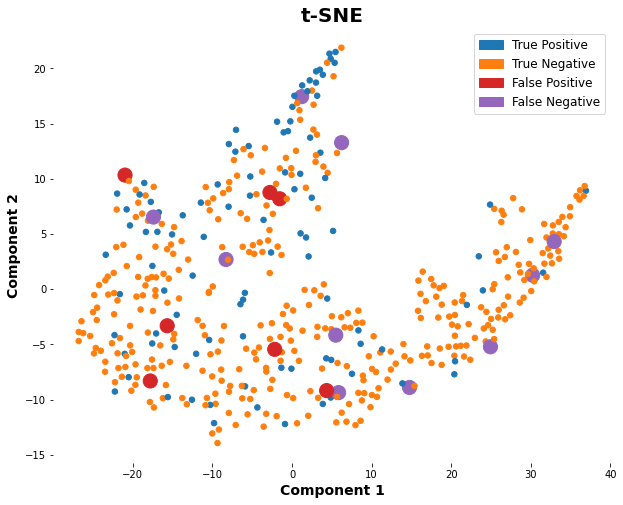

In [71]:
# TSNE
tsne_n = 2
tsne_df = X_train.drop(['Epsilon'], axis = 1, inplace = False)
tsne = TSNE(n_components = tsne_n, random_state = random_seed) 
tsne_columns = ['Component ' + str(i + 1) for i in range(tsne_n)]
x_tsne = tsne.fit_transform(tsne_df)

# create df with the t-SNE components and 'Class'
tsne_df = pd.DataFrame(data = x_tsne, columns = tsne_columns)
tsne_df['Class'] = y_train_class
tsne_df['Error Type'] = y_train_error_type

error_type_map = {'True Positive': 'C0', 'True Negative': 'C1', 'False Positive': 'C3', 'False Negative': 'C4'}
colors = tsne_df['Error Type'].map(error_type_map)

# map error types to sizes
size_map = {'True Positive': 30, 'True Negative': 30, 'False Positive': 200, 'False Negative': 200}
sizes = tsne_df['Error Type'].map(size_map)

legend_elements = [Patch(color=clr, label=lbl) for lbl, clr in error_type_map.items()]

# plot components
plt.figure(figsize = (10, 8))
plt.title('t-SNE', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors, s = sizes)
plt.legend(handles = legend_elements, loc = 'upper right', fontsize = 12)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()


In [ ]:
tsne_neighbor = {}
tsne_neighbor_dist = {}
tsne_df['Class'] = y_train_class
for i, row in tsne_df.iterrows():
    idx, dist = get_closest_same_class(tsne_df, i)
    tsne_neighbor[i] = idx
    tsne_neighbor_dist[i] = dist

tsne_df['TSNE Neighbor'] = pd.Series(tsne_neighbor)
tsne_df['TSNE Neighbor Distance'] = pd.Series(tsne_neighbor_dist)

def tsne_neighbor_category(row):
    if row['TSNE Neighbor'] < 1:
        return 0
    elif row['TSNE Neighbor'] < 4:
        return 1
    else:
        return 2

tsne_df['TSNE Category'] = tsne_df.apply(tsne_neighbor_category, axis = 1)
y_train_tsne = tsne_df['TSNE Category']

# Final Predictions

In [103]:
xtree = ExtraTreesClassifier(random_state = random_seed)

parameters = {
    'criterion': ['log_loss'],
    'n_estimators': [250],
    'max_depth': [12],
    'max_features': [0.5],
    
}

grid_obj = GridSearchCV(xtree, parameters, scoring = balanced_log_loss_scorer , cv = 5)
grid_obj = grid_obj.fit(X_train_meta, y_train_class)
xtree = grid_obj.best_estimator_
xtree.fit(X_train_meta, y_train_class)

ExtraTreesClassifier(criterion='log_loss', max_depth=12, max_features=0.5,
                     n_estimators=250)

In [104]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.423662,0.027979,0.022463,0.001587,log_loss,12,0.5,250,"{'criterion': 'log_loss', 'max_depth': 12, 'ma...",-0.102964,-0.113013,-0.083191,-0.125171,-0.026744,-0.090217,0.034589,1


In [115]:
catboost = CatBoostClassifier(random_state = random_seed, verbose = 0)

parameters = {
    'iterations': [500],
    'learning_rate': [0.02],
    'depth': [9],
    'loss_function': ['Logloss'],
}

grid_obj = GridSearchCV(catboost, parameters, scoring = balanced_log_loss_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train_meta, y_train_class)
catboost = grid_obj.best_estimator_
catboost.fit(X_train_meta, y_train_class)


In [116]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_learning_rate,param_loss_function,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,28.923020,3.381528,0.008073,0.001110,9,500,0.02,Logloss,"{'depth': 9, 'iterations': 500, 'learning_rate...",-0.116791,-0.102021,-0.077769,-0.097281,-0.029298,-0.084632,0.030350,1
0,39.635701,4.177877,0.017382,0.011230,9,500,0.01,Logloss,"{'depth': 9, 'iterations': 500, 'learning_rate...",-0.120548,-0.116586,-0.087309,-0.117332,-0.049643,-0.098284,0.027129,2
3,299.092400,8.168834,0.010943,0.002900,12,500,0.02,Logloss,"{'depth': 12, 'iterations': 500, 'learning_rat...",-0.135995,-0.127484,-0.092695,-0.116617,-0.058414,-0.106241,0.027983,3
2,293.777649,11.061927,0.009668,0.002312,12,500,0.01,Logloss,"{'depth': 12, 'iterations': 500, 'learning_rat...",-0.145907,-0.152331,-0.132638,-0.154899,-0.097128,-0.136581,0.021179,4


In [119]:
X_train_meta

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Model_Min,Model_Max,Model_Mean,Model_Range,XGBoost minus TabPFN,XGBoost minus ExtraTrees,XGBoost minus Guassian,XGBoost x TabPFN,XGBoost x ExtraTrees,XGBoost x Guassian
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.587310,...,0.0,1.0,0.326132,1.0,0.304744,0.269528,0.336418,6.732957e-01,0.708052,0.642035
1,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.734120,...,-0.127747,2.058946,0.423126,2.186693,-0.058946,-0.127747,-0.097995,2.027526e-01,0.231771,0.219223
2,0.209377,2615.81430,85.200147,8.541526,8.138688,4.013127,0.025578,12.547282,1.229900,5237.540880,...,-0.079443,True,0.069638,1.079443,0.000199,-0.010850,-0.079443,1.288570e-08,0.000003,0.000020
3,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,5710.460990,...,-0.299959,True,0.074259,1.299959,0.003596,-0.299959,-0.220557,3.391568e-05,0.002430,0.001803
4,0.269199,966.45483,85.200147,21.174189,8.138688,4.987617,0.025578,9.408886,1.229900,5040.779140,...,-0.213851,True,0.071879,1.213851,0.004316,-0.213851,-0.042110,2.999823e-06,0.001077,0.000232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.807597,1750.88452,85.200147,75.185869,8.138688,5.386272,0.025578,11.639794,2.519538,3957.982330,...,0.0,4.0,0.765231,4.0,0.000544,0.067061,0.142733,5.627778e-01,0.512859,0.456071
613,0.670861,5501.73569,93.822057,6.993026,8.138688,6.511365,0.025578,9.541228,1.229900,4126.619270,...,-0.086064,True,0.069751,1.086064,0.000188,-0.086064,-0.036510,2.870981e-09,0.000017,0.000007
614,0.098279,3042.16022,85.200147,9.385459,8.138688,4.247890,0.128499,9.768100,6.778506,4285.320645,...,-0.244728,True,0.092513,1.244728,-0.122226,-0.055368,-0.244728,1.588894e-02,0.010609,0.025563
615,1.106707,3279.32506,118.764633,48.660064,8.138688,8.212293,0.025578,9.988670,1.229900,6704.193270,...,-0.140124,True,0.070565,1.140124,0.001363,-0.140124,-0.062380,3.267391e-07,0.000223,0.000100


In [118]:
xgboost = XGBClassifier(random_state = random_seed)

parameters = {
    'n_estimators': [250],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.1],
    'reg_lambda': [1, 2],
    'subsample': [0.5],
    'colsample_bytree': [1],
    'colsample_bylevel': [1],
    'colsample_bynode': [1]
}

grid_obj = GridSearchCV(xgboost, parameters, scoring = 'neg_log_loss', cv = 5)
grid_obj = grid_obj.fit(X_train_meta, y_train_class)
xgb = grid_obj.best_estimator_
xgb.fit(X_train_meta, y_train_class)


ValueError: 
All the 120 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\xgboost\sklearn.py", line 1471, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\xgboost\sklearn.py", line 448, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\xgboost\sklearn.py", line 908, in _create_dmatrix
    return DMatrix(**kwargs, nthread=self.n_jobs)
  File "c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\xgboost\core.py", line 743, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
  File "c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\xgboost\data.py", line 970, in dispatch_data_backend
    return _from_pandas_df(data, enable_categorical, missing, threads,
  File "c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\xgboost\data.py", line 417, in _from_pandas_df
    data, feature_names, feature_types = _transform_pandas_df(
  File "c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\xgboost\data.py", line 391, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\xgboost\data.py", line 283, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Model_Min: object, Model_Max: object, Model_Mean: object, Model_Range: object


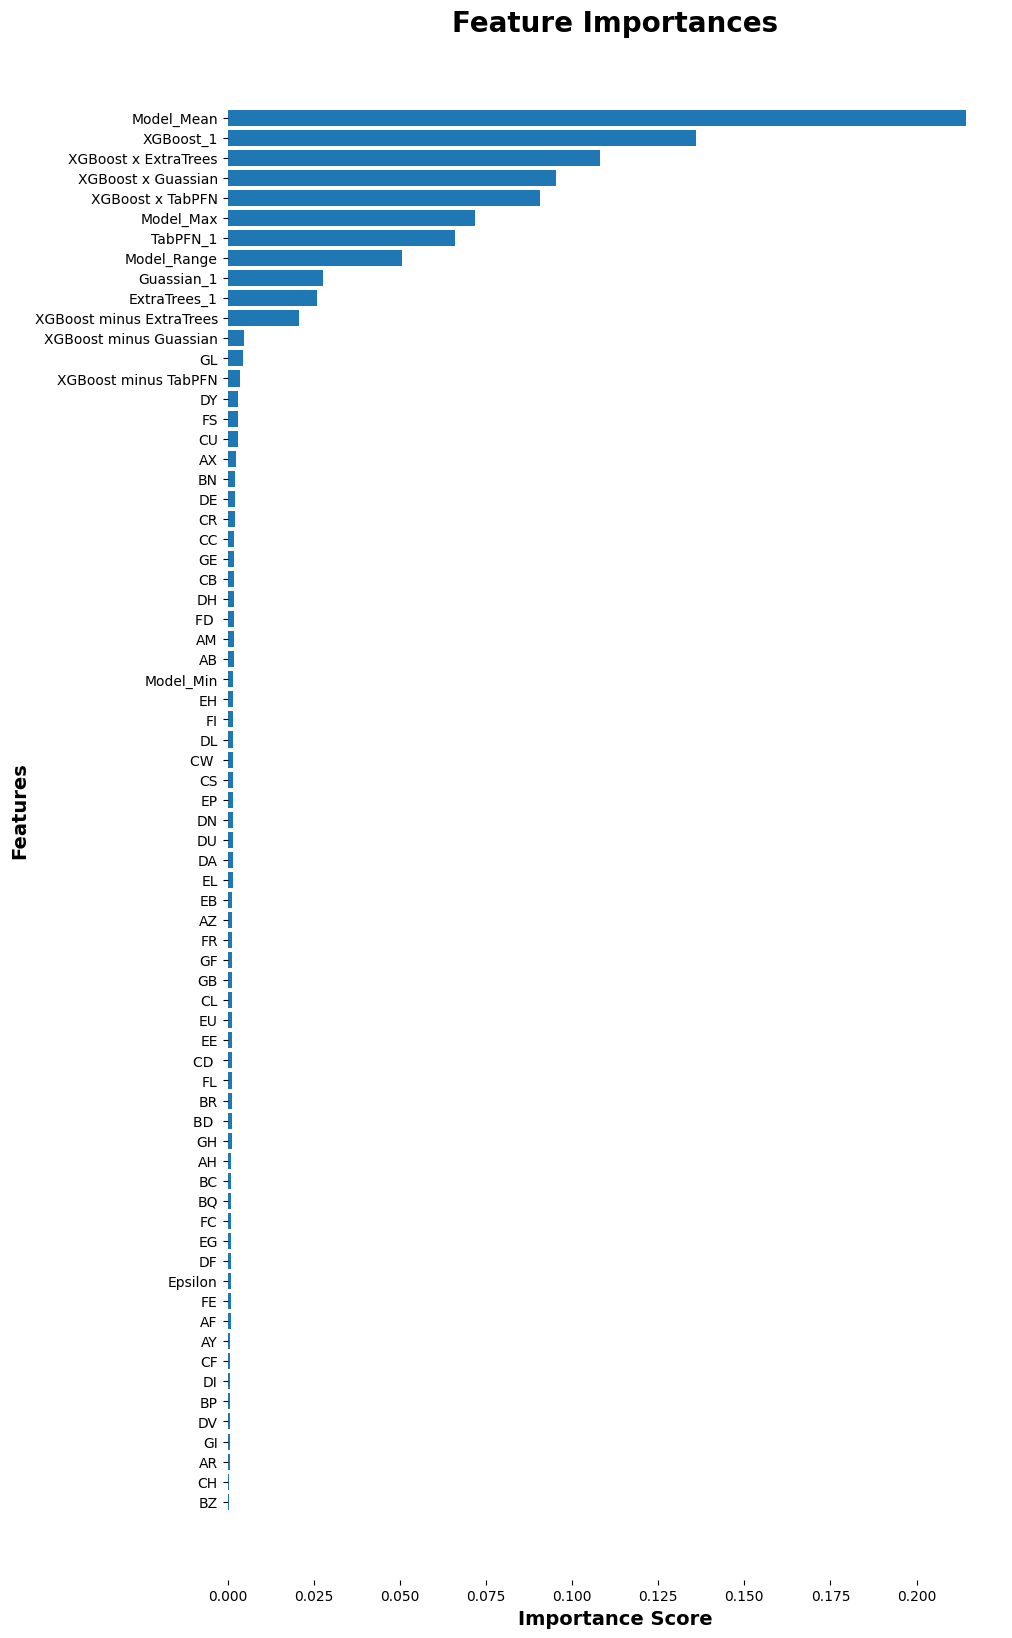

In [105]:
importances = pd.Series(xtree.feature_importances_, index = X_train_meta.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

In [ ]:
train_df[y_train_tsne == 0]['Class'].value_counts()

Class
0    288
1     29
Name: count, dtype: int64

In [ ]:
tsne_df['TSNE Neighbor'].quantile([0.66, 0.9, 0.98])

0.66     0.0
0.90     3.0
0.98    10.0
Name: TSNE Neighbor, dtype: float64

# Error Predictions

In [111]:
xtree_regressor = ExtraTreesRegressor(n_estimators = 250, max_depth = 15, max_features = 0.5, criterion = 'poisson', random_state = random_seed)

In [112]:
prediction_cols = X_train_meta.columns.to_list()
skf = StratifiedKFold(n_splits = 10, random_state = random_seed, shuffle = True)
anomaly_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train_meta, y_train_alpha)):
    fold, oof = X_train_meta.loc[train_index], X_train_meta.loc[test_index]
    fold_y, oof_y = y_train_class[train_index], y_train_class[test_index]
    fold_squared_error, oof_squared_error = y_train_squared_error[train_index], y_train_squared_error[test_index]
    
    # oversample minority class
    fold['Squared Error'] = fold_squared_error
    oof['Squared Error'] = oof_squared_error
    
    # fold, fold_y = ADASYN(random_state = random_seed).fit_resample(fold, fold_y)
    
    fold_y, oof_y = fold['Squared Error'], oof['Squared Error']
    
    fold.drop(columns = ['Squared Error'], inplace = True)
    oof.drop(columns = ['Squared Error'], inplace = True)
    
    xgboost_predictions_df = model_fit_predict_regressor('XGBoost', xgboost_regressor, fold, fold_y, oof, prediction_cols)
    xtree_predictions_df = model_fit_predict_regressor('ExtraTrees', xtree_regressor, fold, fold_y, oof, prediction_cols)

    scaled_fold = scaler.fit_transform(fold)
    scaled_oof = scaler.transform(oof)
    transformed_fold = transformer.fit_transform(scaled_fold)
    transformed_oof = transformer.transform(scaled_oof)
    normalized_fold = normalizer.fit_transform(transformed_fold)
    normalized_oof = normalizer.transform(transformed_oof)
    guassian_fold = pd.DataFrame(transformed_fold, columns = fold.columns, index = fold.index)
    guassian_oof = pd.DataFrame(transformed_oof, columns = fold.columns, index = oof.index)
    

    predictions_df = pd.concat([xgboost_predictions_df, xtree_predictions_df], axis = 1)
    anomaly_prediction_features_df = pd.concat([anomaly_prediction_features_df, predictions_df])
    
anomaly_prediction_features_df.sort_index(inplace = True)
anomaly_prediction_features_df['Anomaly Score_Min'] = anomaly_prediction_features_df.min(axis = 1)
anomaly_prediction_features_df['Anomaly Score_Max'] = anomaly_prediction_features_df.max(axis = 1)
anomaly_prediction_features_df['Anomaly Score_Mean'] = anomaly_prediction_features_df.mean(axis = 1)
anomaly_prediction_features_df['Anomaly Score_Range'] = anomaly_prediction_features_df['Anomaly Score_Max'] - anomaly_prediction_features_df['Anomaly Score_Min']

In [2]:
df = pd.concat([meta_df, anomaly_prediction_features_df], axis = 1)

NameError: name 'pd' is not defined

In [1]:
df.sort_values('Average Squared Error', ascending = False)

NameError: name 'df' is not defined

In [115]:
mean_squared_error(y_train_squared_error, anomaly_prediction_features_df['Anomaly Score_Mean'])

0.005172528471004852

In [100]:
X_train_anomaly = pd.concat([X_train_meta, anomaly_prediction_features_df], axis = 1)

In [101]:
X_train_anomaly

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Model_Min,Model_Max,Model_Mean,Model_Range,XGBoost_Anomaly Score,ExtraTrees_Anomaly Score,Anomaly Score_Min,Anomaly Score_Max,Anomaly Score_Mean,Anomaly Score_Range
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,0.625810,0.971650,0.754682,0.345841,0.075998,0.095114,0.075998,0.095114,0.085556,0.019115
1,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,0.584431,0.670825,0.618152,0.086394,0.085528,0.132438,0.085528,0.132438,0.108983,0.046910
2,0.209377,2615.81430,85.200147,8.541526,8.138688,4.013127,0.025578,12.547282,1.229900,5237.54088,...,0.000045,0.073128,0.031571,0.073083,0.016848,0.001508,0.001508,0.016848,0.009178,0.015340
3,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,5710.46099,...,0.002371,0.301403,0.132813,0.299032,0.021571,0.023931,0.021571,0.023931,0.022751,0.002360
4,0.269199,966.45483,85.200147,21.174189,8.138688,4.987617,0.025578,9.408886,1.229900,5040.77914,...,0.006559,0.303306,0.126244,0.296747,0.024397,0.030582,0.024397,0.030582,0.027489,0.006185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.175193,2607.26686,85.200147,7.067354,8.138688,4.030845,0.025578,3.396778,1.229900,6757.45461,...,0.000088,0.100800,0.042941,0.100712,0.015898,0.002852,0.002852,0.015898,0.009375,0.013046
469,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.001392,0.249921,0.105022,0.248529,0.020603,0.018315,0.018315,0.020603,0.019459,0.002288
470,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,0.010321,0.239174,0.119152,0.228853,0.021254,0.032425,0.021254,0.032425,0.026839,0.011171
471,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.004135,0.309214,0.133973,0.305080,0.024034,0.041690,0.024034,0.041690,0.032862,0.017656


In [37]:
xgboost_regressor = XGBRegressor(random_state = random_seed)

parameters = {
    'booster': ['gbtree'],
    'tree_method': ['auto'],
    'n_estimators': [250],
    'learning_rate': [0.1], 
    'max_depth': [9],
    'gamma': [0.1],
    'reg_lambda': [0.1],
    'colsample_bytree': [0.5],
    'colsample_bylevel': [0.5],
    'colsample_bynode': [0.5]
}

grid_obj = GridSearchCV(xgboost_regressor, parameters, scoring = 'neg_mean_squared_error', cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_squared_error)
xgboost_regressor = grid_obj.best_estimator_
xgboost_regressor.fit(X_train, y_train_squared_error)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=250, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=101010,
             reg_alpha=0, reg_lambda=0.1, ...)

array([0.0633553 , 0.05734553, 0.01776513, 0.02322221, 0.04003315,
       0.02640479, 0.02559724, 0.0609363 , 0.06394759, 0.04157471,
       0.05182708, 0.05506022, 0.04541676, 0.02491045, 0.03853852,
       0.04226399, 0.02255806, 0.02632205, 0.02701985, 0.02733885,
       0.06809302, 0.0348375 , 0.03205721, 0.13294177, 0.23074314,
       0.02286183, 0.04074839, 0.05507362, 0.03372419, 0.02209951,
       0.05682206, 0.0192691 , 0.03263984, 0.04161577, 0.03453968,
       0.0192691 , 0.032344  , 0.06108581, 0.02240417, 0.04297891,
       0.09703628, 0.02191475, 0.02906701, 0.03719193, 0.02821139,
       0.0393448 , 0.02173941, 0.03353083, 0.05423292, 0.05999636,
       0.02523263, 0.02647597, 0.02097067, 0.03227285, 0.02398926,
       0.01906564, 0.04016184, 0.05126999, 0.02188267, 0.1149974 ,
       0.0472272 , 0.01989947, 0.04177023, 0.0462091 , 0.03920344,
       0.02143862, 0.02041201, 0.02722753, 0.01945593, 0.02020112,
       0.08095866, 0.01922995, 0.0175783 , 0.10989626, 0.02100

In [32]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

extra_trees_regressor = ExtraTreesRegressor(random_state=random_seed)

parameters = {
    'n_estimators': [250],
    'max_depth': [15],
    'max_features': [0.5],
    'criterion': ['poisson']
}

grid_obj = GridSearchCV(extra_trees_regressor, parameters, scoring = 'neg_mean_squared_error', cv = 5)
grid_obj = grid_obj.fit(X_train, y_train_squared_error)
extra_trees_regressor = grid_obj.best_estimator_
extra_trees_regressor.fit(X_train, y_train_squared_error)


ExtraTreesRegressor(criterion='poisson', max_depth=15, max_features=0.5,
                    n_estimators=250, random_state=101010)

In [163]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer, Normalizer
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel

# Initialize preprocessing objects
scaler = StandardScaler()
transformer = QuantileTransformer(n_quantiles=10, random_state=random_seed, output_distribution='normal')
normalizer = Normalizer()

# Preprocess X_train
scaled_X_train = scaler.fit_transform(X_train)
transformed_X_train = transformer.fit_transform(scaled_X_train)
normalized_X_train = normalizer.fit_transform(transformed_X_train)
gaussian_X_train = pd.DataFrame(normalized_X_train, columns=X_train.columns, index=X_train.index)

# Gaussian Processes Regressor model
dot_prod = DotProduct(sigma_0 = 1.0, sigma_0_bounds = 'fixed')
white_kernel = WhiteKernel(noise_level = 1, noise_level_bounds = (1e-10, 1e+1))
rbf = RBF(length_scale = 1.0, length_scale_bounds = (1e-1, 1e+1))
constant_kernel = ConstantKernel(constant_value = 1.0, constant_value_bounds = (1e-1, 1e+1))

kernel = dot_prod + white_kernel + rbf * constant_kernel

gpr = GaussianProcessRegressor(kernel = kernel, random_state = random_seed)

# Grid search parameters for Gaussian Processes Regressor
parameters = {
    'alpha': [5],
    'normalize_y': [True]
}

grid_obj = GridSearchCV(gpr, parameters, scoring='neg_mean_squared_error', cv=5)
grid_obj = grid_obj.fit(gaussian_X_train, y_train_squared_error)
gpr = grid_obj.best_estimator_
gpr.fit(gaussian_X_train, y_train_squared_error)


GaussianProcessRegressor(alpha=5,
                         kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1) + RBF(length_scale=1) * 1**2,
                         normalize_y=True, random_state=101010)

In [119]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR()

parameters = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3, 0.5],
    'degree': [3, 4, 5], # degree of the polynomial kernel function ('poly')
    'coef0': [0.0, 0.1, 0.5, 1.0], # independent term in kernel function. Only significant in 'poly' and 'sigmoid'.
    'cache_size': [10000],
}

grid_obj = GridSearchCV(svr, parameters, scoring='neg_mean_squared_error', cv=5)
grid_obj = grid_obj.fit(X_train_meta, y_train_squared_error)
svr = grid_obj.best_estimator_
svr.fit(X_train_meta, y_train_squared_error)

In [ ]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_coef0,param_epsilon,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
43,0.001271,0.000090,0.000752,0.000075,0.1,0.1,0.1,auto,sigmoid,"{'C': 0.1, 'coef0': 0.1, 'epsilon': 0.1, 'gamm...",-0.009456,-0.011081,-0.012650,-0.008605,-1.248442e-02,-0.010855,0.001609,1
129,0.001174,0.000044,0.000685,0.000020,0.1,1.0,0.1,10,sigmoid,"{'C': 0.1, 'coef0': 1.0, 'epsilon': 0.1, 'gamm...",-0.009456,-0.011081,-0.012650,-0.008605,-1.248442e-02,-0.010855,0.001609,1
127,0.001199,0.000068,0.000671,0.000014,0.1,1.0,0.1,1,sigmoid,"{'C': 0.1, 'coef0': 1.0, 'epsilon': 0.1, 'gamm...",-0.009456,-0.011081,-0.012650,-0.008605,-1.248442e-02,-0.010855,0.001609,1
125,0.001249,0.000129,0.000696,0.000032,0.1,1.0,0.1,0.1,sigmoid,"{'C': 0.1, 'coef0': 1.0, 'epsilon': 0.1, 'gamm...",-0.009456,-0.011081,-0.012650,-0.008605,-1.248442e-02,-0.010855,0.001609,1
123,0.001238,0.000070,0.000727,0.000065,0.1,1.0,0.1,auto,sigmoid,"{'C': 0.1, 'coef0': 1.0, 'epsilon': 0.1, 'gamm...",-0.009456,-0.011081,-0.012650,-0.008605,-1.248442e-02,-0.010855,0.001609,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0.005730,0.000095,0.001621,0.000014,100,0.1,0.2,scale,sigmoid,"{'C': 100, 'coef0': 0.1, 'epsilon': 0.2, 'gamm...",-661211.829736,-654221.617081,-427141.528864,-299363.232776,-8.954697e+05,-587481.587847,206624.392219,636
541,0.005744,0.000123,0.001653,0.000104,100,0.1,0.3,scale,sigmoid,"{'C': 100, 'coef0': 0.1, 'epsilon': 0.3, 'gamm...",-661255.586032,-654201.876309,-427117.862311,-299397.989311,-8.957483e+05,-587544.330184,206703.291138,637
481,0.006453,0.000144,0.001764,0.000039,100,0.0,0.1,scale,sigmoid,"{'C': 100, 'coef0': 0.0, 'epsilon': 0.1, 'gamm...",-829739.385157,-826530.536969,-526793.350497,-372577.261605,-1.145838e+06,-740295.653529,268589.301338,638
491,0.006528,0.000103,0.001836,0.000124,100,0.0,0.2,scale,sigmoid,"{'C': 100, 'coef0': 0.0, 'epsilon': 0.2, 'gamm...",-829794.317557,-826540.856850,-526855.361645,-372555.572773,-1.145876e+06,-740324.491396,268601.365168,639


In [79]:
meta_prediction_features_df[meta_prediction_features_df['Class'] == 1].sort_values(by = 'Average Squared Error', ascending = False).head(20)

,XGBoost_1,CatBoost_1,HistBoost_1,ExtraTrees_1,TabPFN_1,Guassian_1,Model_Min,Model_Max,Model_Mean,Model_Range,...,CatBoost_Error,HistBoost_Error,ExtraTrees_Error,TabPFN_Error,Guassian_Error,Total_Error,Average Squared Error,Isolation Forest,Isolation Forest_0,Isolation Forest_1
393,0.001290,0.002550,0.002255,0.029608,0.000017,0.059743,0.000017,0.059743,0.019403,0.059727,...,1,1,1,1,1,5,0.963726,0,1,1
114,0.030080,0.023268,0.126752,0.120719,0.027129,0.273243,0.023268,0.273243,0.112213,0.249975,...,1,1,1,1,1,5,0.790219,0,1,1
201,0.030342,0.352422,0.162672,0.425532,0.009639,0.096473,0.009639,0.425532,0.189031,0.415893,...,1,1,1,1,1,5,0.753709,0,1,1
243,0.040252,0.199351,0.028372,0.320743,0.066496,0.248431,0.028372,0.320743,0.156595,0.292370,...,1,1,1,1,1,5,0.752571,0,1,1
24,0.049688,0.188671,0.063584,0.612372,0.290818,0.411034,0.049688,0.612372,0.284779,0.562683,...,1,1,0,1,1,4,0.556008,1,-1,-1
339,0.220040,0.422638,0.344696,0.465236,0.031650,0.317144,0.031650,0.465236,0.287286,0.433586,...,1,1,1,1,1,5,0.545546,0,1,1
341,0.252322,0.221168,0.370179,0.374706,0.228746,0.388974,0.221168,0.388974,0.305780,0.167806,...,1,1,1,1,1,5,0.462975,0,1,1
115,0.115666,0.261360,0.130124,0.517884,0.644019,0.499420,0.115666,0.644019,0.366020,0.528353,...,1,1,0,0,1,3,0.429694,0,1,1
329,0.241359,0.263591,0.151624,0.365973,0.621900,0.689465,0.151624,0.689465,0.396875,0.537841,...,1,1,1,0,0,3,0.387332,0,1,1
322,0.289800,0.335078,0.335544,0.455074,0.587373,0.526313,0.289800,0.587373,0.425794,0.297573,...,1,1,1,0,0,3,0.327494,0,1,1


In [84]:
from sklearn.ensemble import IsolationForest
import numpy as np

# train isolation forest for class 0
model_0 = IsolationForest(contamination=0.01)
model_0.fit(X_train[y_train_class == 0])

# train isolation forest for class 1
model_1 = IsolationForest(contamination=0.01)
model_1.fit(X_train[y_train_class == 1])

# predict the anomaly scores
anomaly_scores_0 = model_0.decision_function(X_train)
anomaly_scores_1 = model_1.decision_function(X_train)

# normalize the scores to be between 0 and 1
anomaly_scores_0 = (anomaly_scores_0 - np.min(anomaly_scores_0)) / (np.max(anomaly_scores_0) - np.min(anomaly_scores_0))
anomaly_scores_1 = (anomaly_scores_1 - np.min(anomaly_scores_1)) / (np.max(anomaly_scores_1) - np.min(anomaly_scores_1))



c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\c.gendron1\AppData\Local\miniconda3\envs\playground\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [86]:
anomaly_scores_1

array([0.82423636, 0.8771963 , 0.85061774, 0.79602414, 0.91798963,
       0.93636867, 0.93789174, 0.40511144, 0.87056581, 0.93293699,
       0.80875205, 0.63411864, 0.71895459, 0.85405133, 0.84451251,
       0.84247146, 0.90379887, 0.91237236, 0.81610126, 0.97719296,
       0.7192378 , 0.80382628, 0.94773141, 0.92530161, 0.6388442 ,
       0.70400903, 0.89632769, 0.93214392, 0.85824856, 0.88875411,
       0.81555395, 0.8752725 , 0.90901157, 0.88724668, 0.97383232,
       0.83902828, 0.97230282, 0.97143469, 0.88759861, 0.85164521,
       0.09173372, 0.96124423, 0.89167   , 0.72009185, 0.8993117 ,
       0.91331353, 0.94789995, 0.95155637, 0.95278697, 0.68952675,
       0.64296177, 0.90301649, 0.86456705, 0.98975264, 0.83703782,
       0.87580856, 0.96591752, 0.81219917, 0.93671978, 0.66352105,
       0.77298136, 0.92195869, 0.85951802, 0.87917611, 0.94166007,
       0.85692534, 0.826459  , 0.82582611, 0.92040276, 0.80955624,
       0.8737781 , 0.8749844 , 0.92627324, 0.7948012 , 0.79578

In [61]:
# change array to list
y_pred_anomalies = list(y_pred_anomalies)
y_pred_anomalies = [1 if x == -1 else 0 for x in y_pred_anomalies]

In [67]:
meta_prediction_features_df['Isolation Forest_0'] = y_pred_anomalies_0
meta_prediction_features_df['Isolation Forest_1'] = y_pred_anomalies_1

In [ ]:
met

In [62]:
accuracy_score(y_train_anomalies, y_pred_anomalies)

0.8498942917547568

In [74]:
for error in [1, 2, 3]:
    df = meta_prediction_features_df[meta_prediction_features_df['Total_Error'] == error]
    for col in ['XGBoost_Error', 'CatBoost_Error', 'HistBoost_Error', 'ExtraTrees_Error', 'TabPFN_Error', 'Guassian_Error']:
        col_errors = df[col].sum()
        df_len = len(df)
        print(f'{col} error {error} count: {col_errors} ({col_errors / df_len})')
        
    print()

XGBoost_Error error 1 count: 5 (0.19230769230769232)
CatBoost_Error error 1 count: 3 (0.11538461538461539)
HistBoost_Error error 1 count: 3 (0.11538461538461539)
ExtraTrees_Error error 1 count: 6 (0.23076923076923078)
TabPFN_Error error 1 count: 7 (0.2692307692307692)
Guassian_Error error 1 count: 8 (0.3076923076923077)

XGBoost_Error error 2 count: 10 (0.5555555555555556)
CatBoost_Error error 2 count: 11 (0.6111111111111112)
HistBoost_Error error 2 count: 10 (0.5555555555555556)
ExtraTrees_Error error 2 count: 9 (0.5)
TabPFN_Error error 2 count: 7 (0.3888888888888889)
Guassian_Error error 2 count: 10 (0.5555555555555556)

XGBoost_Error error 3 count: 6 (0.6666666666666666)
CatBoost_Error error 3 count: 6 (0.6666666666666666)
HistBoost_Error error 3 count: 5 (0.5555555555555556)
ExtraTrees_Error error 3 count: 7 (0.7777777777777778)
TabPFN_Error error 3 count: 6 (0.6666666666666666)
Guassian_Error error 3 count: 8 (0.8888888888888888)



In [68]:
meta_prediction_features_df['Total_Error'].value_counts()

Total_Error
0    412
1     26
2     18
3      9
4      8
Name: count, dtype: int64

In [84]:
scaled_log_loss = StandardScaler().fit_transform(np.array(log_loss[0:-1]).reshape(-1, 1))

In [ ]:
[3.2, 3, 3.1, 0.5, 1.5, 1]

In [85]:
scaled_log_loss

array([[-1.23114834],
       [-0.98128626],
       [-1.11065803],
       [ 1.16246961],
       [ 0.22043499],
       [ 0.91671881],
       [ 1.02346921]])

In [79]:
xgb = XGBClassifier()
xgb.fit(X_train_anomaly, y_train_class)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

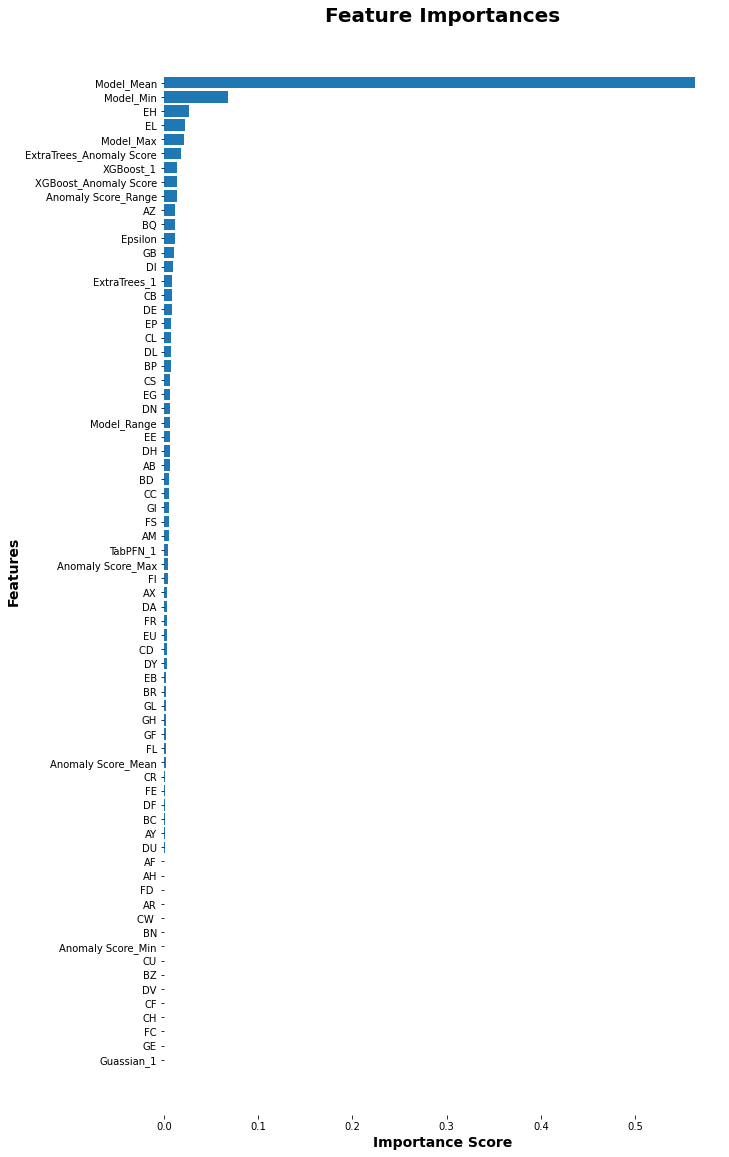

In [80]:
importances = pd.Series(xgb.feature_importances_, index = X_train_anomaly.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

In [57]:
meta_prediction_features_df[
    (meta_prediction_features_df['Model_Min'] > 0.5) &
    (meta_prediction_features_df['Class'] == 0)
]

,XGBoost_1,CatBoost_1,HistBoost_1,ExtraTrees_1,TabPFN_1,LogisticRegression_1,Guassian_1,Model_Min,Model_Max,Model_Mean,Model_Range,Class,XGBoost_Error,CatBoost_Error,HistBoost_Error,ExtraTrees_Error,TabPFN_Error,LogisticRegression_Error,Guassian_Error,Total_Error
83,0.810938,0.888906,0.810118,0.561482,0.964201,0.991152,0.726174,0.561482,0.991152,0.811734,0.429670,0,1,1,1,1,1,1,1,5
429,0.971325,0.881069,0.939826,0.670945,0.501071,0.661510,0.580125,0.501071,0.971325,0.742030,0.470255,0,1,1,1,1,1,1,1,5


In [62]:
# if Model_Min > 0.75 then 1
# if Model_Max < 0.25 then 0

def binary_prediction(row):
    if row['Model_Min'] > 0.75:
        return 1
    elif row['Model_Max'] < 0.25:
        return 0.01
    else:
        return (row['XGBoost_1'] + row['TabPFN_1']) / 2
    
meta_prediction_features_df['Binary Prediction'] = meta_prediction_features_df.apply(binary_prediction, axis = 1)

In [146]:
meta_prediction_features_df[
    (meta_prediction_features_df['Binary Prediction'] == 0) &
    (meta_prediction_features_df['Class'] == 1)]

,XGBoost_1,CatBoost_1,HistBoost_1,ExtraTrees_1,TabPFN_1,LogReg_1,Model_Min,Model_Max,Model_Mean,Model_Range,Class,XGBoost_Error,CatBoost_Error,HistBoost_Error,ExtraTrees_Error,TabPFN_Error,LogReg_Error,Total_Error,Binary Prediction
114,0.03008,0.019396,0.126752,0.120719,0.027134,0.100063,0.019396,0.126752,0.071286,0.107356,1,1,1,1,1,1,1,5,0.0
393,0.00129,0.002550,0.002255,0.029608,0.000017,0.010326,0.000017,0.029608,0.009459,0.029591,1,1,1,1,1,1,1,5,0.0


In [61]:
meta_prediction_features_df[['XGBoost_1', 'CatBoost_1', 'HistBoost_1', 'ExtraTrees_1', 'TabPFN_1', 'LogisticRegression_1', 'Guassian_1']].corr()

,XGBoost_1,CatBoost_1,HistBoost_1,ExtraTrees_1,TabPFN_1,LogisticRegression_1,Guassian_1
XGBoost_1,1.000000,0.973695,0.977740,0.898266,0.902545,0.853089,0.880154
CatBoost_1,0.973695,1.000000,0.963322,0.920640,0.900814,0.873678,0.890210
HistBoost_1,0.977740,0.963322,1.000000,0.895481,0.885351,0.844566,0.868222
ExtraTrees_1,0.898266,0.920640,0.895481,1.000000,0.882715,0.844058,0.884304
TabPFN_1,0.902545,0.900814,0.885351,0.882715,1.000000,0.820173,0.927167
LogisticRegression_1,0.853089,0.873678,0.844566,0.844058,0.820173,1.000000,0.845389
Guassian_1,0.880154,0.890210,0.868222,0.884304,0.927167,0.845389,1.000000


In [58]:
meta_prediction_features_df[['XGBoost_Error', 'CatBoost_Error', 'HistBoost_Error', 'ExtraTrees_Error', 'TabPFN_Error', 'LogisticRegression_Error', 'Guassian_Error']].corr()

,XGBoost_Error,CatBoost_Error,HistBoost_Error,ExtraTrees_Error,TabPFN_Error,LogisticRegression_Error,Guassian_Error
XGBoost_Error,1.000000,0.725647,0.786971,0.620501,0.346668,0.422603,0.474784
CatBoost_Error,0.725647,1.000000,0.631688,0.643780,0.423624,0.466691,0.469990
HistBoost_Error,0.786971,0.631688,1.000000,0.597061,0.367971,0.403727,0.422421
ExtraTrees_Error,0.620501,0.643780,0.597061,1.000000,0.412564,0.329050,0.431332
TabPFN_Error,0.346668,0.423624,0.367971,0.412564,1.000000,0.259408,0.589190
LogisticRegression_Error,0.422603,0.466691,0.403727,0.329050,0.259408,1.000000,0.404673
Guassian_Error,0.474784,0.469990,0.422421,0.431332,0.589190,0.404673,1.000000


In [59]:
meta_prediction_features_df['Test Mean'] = (meta_prediction_features_df['XGBoost_1'] + 
    meta_prediction_features_df['ExtraTrees_1'] +
    meta_prediction_features_df['TabPFN_1'] +
    meta_prediction_features_df['Guassian_1']) / 4

In [63]:

competition_log_loss(meta_prediction_features_df['Class'], meta_prediction_features_df['Binary Prediction'])

0.22974999279950434

In [155]:
train_df.loc[114]

AB           0.730683
AF           1070.729
AH         123.223641
AM          36.470272
AR           8.138688
              ...    
Alpha               D
Beta                B
Gamma               E
Delta               A
Epsilon          3057
Name: 114, Length: 61, dtype: object

# Final Prediction

In [351]:
xgb = XGBClassifier()
catboost = CatBoostClassifier(verbose = False)
histboost = HistGradientBoostingClassifier()
xtree = ExtraTreesClassifier()
dtree = DecisionTreeClassifier()

In [353]:
prediction_cols = X_train_meta.columns.to_list()
skf = StratifiedKFold(n_splits = 10, random_state = random_seed, shuffle = True)
final_prediction_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train_meta, y_train_error)):
    fold, oof = X_train_meta.loc[train_index], X_train_meta.loc[test_index]
    fold_y, oof_y = y_train_class[train_index], y_train_class[test_index]
    fold_error = y_train_error[train_index]
    
    # oversample errors
    fold['Class'] = fold_y
    fold, fold_y = ADASYN(random_state = random_seed).fit_resample(fold, fold_error)
    fold_y = fold['Class']
    fold.drop(columns = ['Class'], inplace = True)
    
    # fit models and get predictions
    xgboost_predictions_df = model_fit_predict('XGBoost', xgb, fold, fold_y, oof, prediction_cols)
    catboost_predictions_df = model_fit_predict('CatBoost', catboost, fold, fold_y, oof, prediction_cols)
    histboost_predictions_df = model_fit_predict('HistBoost', histboost, fold, fold_y, oof, prediction_cols)
    xtree_predictions_df = model_fit_predict('ExtraTrees', xtree, fold, fold_y, oof, prediction_cols)
    dtree_predictions_df = model_fit_predict('DecisionTree', dtree, fold, fold_y, oof, prediction_cols)
    
    predictions_df = pd.concat([xtree_predictions_df, dtree_predictions_df], axis = 1)
    final_prediction_df = pd.concat([final_prediction_df, predictions_df])
    
final_prediction_df.sort_index(inplace = True)
final_prediction_df['Model_Min'] = final_prediction_df.min(axis = 1)
final_prediction_df['Model_Max'] = final_prediction_df.max(axis = 1)
final_prediction_df['Model_Mean'] = final_prediction_df.mean(axis = 1)
final_prediction_df['Model_Range'] = final_prediction_df['Model_Max'] - final_prediction_df['Model_Min']


In [358]:
final_prediction_df

,ExtraTrees_1,DecisionTree_1,Model_Min,Model_Max,Model_Mean,Model_Range
0,0.81,1.0,0.81,1.00,0.905,0.19
1,0.49,1.0,0.49,1.00,0.745,0.51
2,0.01,0.0,0.00,0.01,0.005,0.01
3,0.02,0.0,0.00,0.02,0.010,0.02
4,0.07,0.0,0.00,0.07,0.035,0.07
...,...,...,...,...,...,...
468,0.00,0.0,0.00,0.00,0.000,0.00
469,0.05,0.0,0.00,0.05,0.025,0.05
470,0.07,0.0,0.00,0.07,0.035,0.07
471,0.18,1.0,0.18,1.00,0.590,0.82


In [357]:
competition_log_loss(y_train_class, final_prediction_df['DecisionTree_1'])

5.96192551951217

In [342]:
y_train_error = meta_prediction_features_df['Total_Error']

In [278]:
meta_prediction_features_df[['XGBoost_Error', 'CatBoost_Error', 'HistBoost_Error', 'ExtraTrees_Error', 'TabPFN_Error', 'Total_Error']].corr()

,XGBoost_Error,CatBoost_Error,HistBoost_Error,ExtraTrees_Error,TabPFN_Error,Total_Error
XGBoost_Error,1.000000,0.720094,0.664966,0.634976,0.396949,0.853079
CatBoost_Error,0.720094,1.000000,0.660937,0.601023,0.341471,0.832355
HistBoost_Error,0.664966,0.660937,1.000000,0.609630,0.359538,0.828175
ExtraTrees_Error,0.634976,0.601023,0.609630,1.000000,0.460996,0.834732
TabPFN_Error,0.396949,0.341471,0.359538,0.460996,1.000000,0.638984
Total_Error,0.853079,0.832355,0.828175,0.834732,0.638984,1.000000


In [288]:
meta_prediction_features_df[['XGBoost_1', 'CatBoost_1', 'HistBoost_1', 'ExtraTrees_1', 'TabPFN_1']].corr()

,XGBoost_1,CatBoost_1,HistBoost_1,ExtraTrees_1,TabPFN_1
XGBoost_1,1.000000,0.966831,0.965993,0.898565,0.893901
CatBoost_1,0.966831,1.000000,0.957182,0.916008,0.889404
HistBoost_1,0.965993,0.957182,1.000000,0.891946,0.877435
ExtraTrees_1,0.898565,0.916008,0.891946,1.000000,0.874645
TabPFN_1,0.893901,0.889404,0.877435,0.874645,1.000000


In [199]:
meta_prediction_features_df['Total_Error'] = meta_prediction_features_df['TabPFN_Error'] + meta_prediction_features_df['XGBoost_Error'] + meta_prediction_features_df['ExtraTrees_Error'] + meta_prediction_features_df['HistBoost_Error']

In [201]:
meta_prediction_features_df.sort_values(by = 'Total_Error', ascending = False).head(20)

,TabPFN_0,TabPFN_1,XGBoost_0,XGBoost_1,ExtraTrees_0,ExtraTrees_1,HistBoost_0,HistBoost_1,Class,TabPFN_Error,XGBoost_Error,ExtraTrees_Error,HistBoost_Error,Total_Error
223,0.254194,0.745806,0.032111,0.967889,0.384984,0.615016,0.000013,9.999867e-01,0,1,1,1,1,4
129,0.619700,0.380300,0.732837,0.267163,0.562423,0.437577,0.592678,4.073220e-01,1,1,1,1,1,4
23,0.734374,0.265626,0.513393,0.486607,0.632924,0.367076,0.967826,3.217448e-02,1,1,1,1,1,4
150,0.336170,0.663830,0.265704,0.734296,0.380072,0.619928,0.007373,9.926269e-01,0,1,1,1,1,4
243,0.891208,0.108792,0.975256,0.024744,0.626785,0.373215,0.998827,1.173094e-03,1,1,1,1,1,4
429,0.246305,0.753695,0.057572,0.942428,0.360878,0.639122,0.003587,9.964131e-01,0,1,1,1,1,4
114,0.948815,0.051185,0.987926,0.012074,0.857790,0.142210,0.999915,8.479457e-05,1,1,1,1,1,4
201,0.860186,0.139814,0.933797,0.066203,0.510620,0.489380,0.998076,1.923746e-03,1,1,1,1,1,4
329,0.682510,0.317490,0.632493,0.367507,0.607266,0.392734,0.929493,7.050663e-02,1,1,1,1,1,4
322,0.638593,0.361407,0.704771,0.295229,0.570933,0.429067,0.917007,8.299280e-02,1,1,1,1,1,4


In [292]:
meta_prediction_features_df[
    (meta_prediction_features_df['Model_Min'] > 0.5) &
    (meta_prediction_features_df['Class'] == 0)
]

,XGBoost_1,CatBoost_1,HistBoost_1,ExtraTrees_1,TabPFN_1,Model_Min,Model_Max,Model_Mean,Model_Range,Class,XGBoost_Error,CatBoost_Error,HistBoost_Error,ExtraTrees_Error,TabPFN_Error,Total_Error
153,0.587919,0.802335,0.939249,0.606030,0.709931,0.587919,0.939249,0.738947,0.351330,0,1,1,1,1,1,5
223,0.986106,0.918111,0.992375,0.638678,0.540118,0.540118,0.992375,0.801126,0.452256,0,1,1,1,1,1,5


In [188]:
meta_prediction_features_df[['TabPFN_1', 'XGBoost_1', 'ExtraTrees_1', 'HistBoost_1']].corr()

,TabPFN_Error,XGBoost_Error,ExtraTrees_Error,HistBoost_Error
TabPFN_Error,1.000000,0.717587,0.572232,0.795145
XGBoost_Error,0.717587,1.000000,0.522835,0.657572
ExtraTrees_Error,0.572232,0.522835,1.000000,0.491907
HistBoost_Error,0.795145,0.657572,0.491907,1.000000


In [294]:
print(competition_log_loss(y_train_class, meta_prediction_features_df['XGBoost_1']))
print(roc_auc_score(y_train_class, meta_prediction_features_df['HistBoost_1']))

0.252032177021214
0.9641806189751395


In [189]:
print(competition_log_loss(y_train_class, meta_prediction_features_df['ExtraTrees_1']))
print(roc_auc_score(y_train_class, meta_prediction_features_df['ExtraTrees_1']))

0.3568475541170984
0.9713850837138508


In [190]:
print(competition_log_loss(y_train_class, meta_prediction_features_df['XGBoost_1']))
print(roc_auc_score(y_train_class, meta_prediction_features_df['XGBoost_1']))

0.24013222084624092
0.9730339928970065


In [191]:
print(competition_log_loss(y_train_class, meta_prediction_features_df['Alpha_1']))
print(roc_auc_score(y_train_class, meta_prediction_features_df['Alpha_1']))

0.2481177592369384
0.976103500761035


In [170]:

alpha_predictions = meta_prediction_features_df['Alpha_1'] > 0.5

# Compare predictions to true labels
y_train_error = y_train_class != alpha_predictions
y_train_error.value_counts()


False    449
True      24
Name: count, dtype: int64

In [166]:
y_train_error = y_train_error.astype(int)

In [164]:
y_train_error.astype(int)

0      0
1      1
2      0
3      0
4      0
      ..
468    0
469    0
470    0
471    0
472    0
Length: 473, dtype: int64

In [152]:
y_train_tsne.value_counts()

TSNE Category
0    317
1    112
2     33
3     11
Name: count, dtype: int64

In [153]:
print(11/317)
print(9/112)
print(5/33)
print(1/11)

0.03470031545741325
0.08035714285714286
0.15151515151515152
0.09090909090909091


In [148]:
y_train_error

0      False
1       True
2      False
3      False
4      False
       ...  
468    False
469    False
470    False
471    False
472    False
Length: 473, dtype: bool

In [234]:
test_df = pd.concat([test_df, meta_prediction_features_df], axis = 1)

In [226]:
test_df['Class'] = y_train_class

In [235]:
test_df[test_df['Class'] == 1]

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Principal Component 3,Alpha_0,Alpha_1,PCA_0,PCA_1,Class,PCA_0,PCA_1,Alpha_0,Alpha_1
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.587310,...,2.496944,0.140826,0.859174,0.147047,0.852953,1,0.112231,0.887769,0.120223,0.879777
1,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.734120,...,0.242536,0.790020,0.209980,0.847286,0.152714,1,0.827252,0.172748,0.695551,0.304449
7,0.504214,6089.31532,85.200147,189.781063,17.027268,6.201300,10.315851,14.494600,212.628626,43882.278500,...,1.207766,0.205311,0.794689,0.195143,0.804857,1,0.213037,0.786963,0.178114,0.821886
10,0.534125,4784.80222,90.704235,8.739734,8.138688,7.003039,0.025578,10.152522,14.836108,5535.144410,...,0.624691,0.168153,0.831847,0.189689,0.810311,1,0.160927,0.839073,0.123781,0.876219
23,0.743502,3447.90831,85.200147,79.431856,8.138688,5.262246,0.025578,12.364524,11.026932,8264.975850,...,0.287981,0.744933,0.255067,0.817153,0.182847,1,0.793276,0.206724,0.692290,0.307710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,0.517033,3749.95214,97.140186,14.980189,8.138688,4.358628,0.037758,15.893644,4.687676,5694.429055,...,-2.180945,0.454789,0.545211,0.277231,0.722769,1,0.244829,0.755171,0.623119,0.376881
446,2.371515,7040.37048,846.122895,22.793920,8.138688,5.616606,0.025578,17.336802,4.230856,3659.779550,...,-2.433451,0.126967,0.873033,0.145938,0.854062,1,0.133195,0.866805,0.144967,0.855033
448,0.247834,3980.79473,85.200147,14.512542,11.279844,5.528016,0.025578,3.396778,3.629962,4025.018430,...,3.410385,0.049943,0.950057,0.060331,0.939669,1,0.043858,0.956142,0.030570,0.969430
452,0.508487,3692.13592,110.621718,13.859075,8.138688,5.377413,0.025578,11.608284,3.756466,4987.597700,...,-1.552249,0.158292,0.841708,0.219373,0.780627,1,0.188125,0.811875,0.137353,0.862647


In [203]:
test_df['Class'] = y_train_class
test_df[test_df['Class'] == 1].sort_values

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Principal Component 1,Principal Component 2,Principal Component 3,Alpha_0,Alpha_1,PCA_0,PCA_1,Alpha_0,Alpha_1,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.587310,...,-1.337965,-4.492296,2.496944,0.147047,0.852953,0.019895,0.980105,0.016535,0.983465,1
1,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.734120,...,1.559112,-1.034846,0.242536,0.847286,0.152714,0.864411,0.135589,0.875837,0.124163,1
7,0.504214,6089.31532,85.200147,189.781063,17.027268,6.201300,10.315851,14.494600,212.628626,43882.278500,...,2.482982,5.417420,1.207766,0.195143,0.804857,0.071571,0.928429,0.084489,0.915511,1
10,0.534125,4784.80222,90.704235,8.739734,8.138688,7.003039,0.025578,10.152522,14.836108,5535.144410,...,1.536635,3.399271,0.624691,0.189689,0.810311,0.023024,0.976976,0.020403,0.979597,1
23,0.743502,3447.90831,85.200147,79.431856,8.138688,5.262246,0.025578,12.364524,11.026932,8264.975850,...,3.991148,0.389231,0.287981,0.817153,0.182847,0.921602,0.078398,0.909322,0.090678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,0.517033,3749.95214,97.140186,14.980189,8.138688,4.358628,0.037758,15.893644,4.687676,5694.429055,...,-1.611291,0.835160,-2.180945,0.277231,0.722769,0.018923,0.981077,0.052563,0.947437,1
446,2.371515,7040.37048,846.122895,22.793920,8.138688,5.616606,0.025578,17.336802,4.230856,3659.779550,...,3.885205,4.503112,-2.433451,0.145938,0.854062,0.084759,0.915241,0.060014,0.939986,1
448,0.247834,3980.79473,85.200147,14.512542,11.279844,5.528016,0.025578,3.396778,3.629962,4025.018430,...,1.713285,-3.683640,3.410385,0.060331,0.939669,0.010955,0.989045,0.012186,0.987814,1
452,0.508487,3692.13592,110.621718,13.859075,8.138688,5.377413,0.025578,11.608284,3.756466,4987.597700,...,3.207233,-1.113420,-1.552249,0.219373,0.780627,0.084285,0.915715,0.080671,0.919329,1


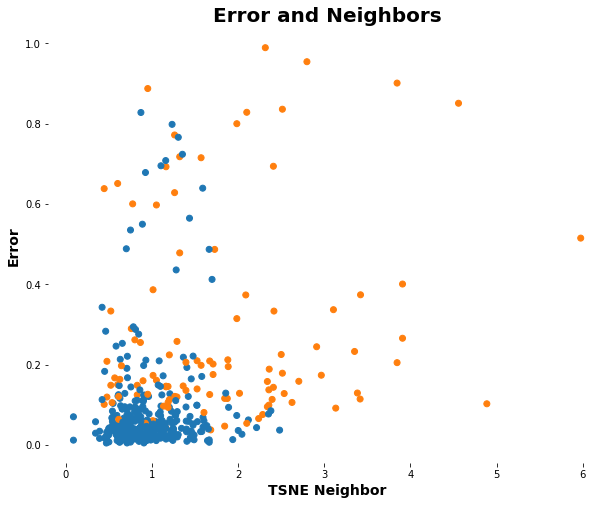

In [191]:
colors = test_df['Class'].map(class_color_map)

plt.figure(figsize = (10, 8))
plt.title('Error and Neighbors', fontdict = font_dict_header)
plt.box(False)
plt.scatter(test_df['TSNE Neighbor Distance'], test_df['Error'], c = colors)
plt.xlabel('TSNE Neighbor', fontdict = font_dict_axistitle)
plt.ylabel('Error', fontdict = font_dict_axistitle)

plt.show()

## Alpha Predictions

In [573]:
# gather time series data on alpha
X_train['Weeks Since 1-1-2019'] = train_df['Weeks Since 1-1-2019'].copy()
alpha_cols = ['Alpha_0', 'Alpha_1', 'Alpha_2', 'Alpha_3']
rolling_means = [24]
shift = 2

alpha_time_df = pd.get_dummies(y_train_alpha, prefix = 'Alpha')
alpha_time_df = pd.concat([X_train[['Weeks Since 1-1-2019']], alpha_time_df.astype(int)], axis = 1)

alpha_time_df = alpha_time_df.groupby('Weeks Since 1-1-2019').sum()[alpha_cols]
alpha_time_df['Count'] = alpha_time_df['Alpha_0'] + alpha_time_df['Alpha_1'] + alpha_time_df['Alpha_2'] + alpha_time_df['Alpha_3']

alpha_time_df = alpha_time_df.reindex(range(min(X_train['Weeks Since 1-1-2019']), max(X_train['Weeks Since 1-1-2019']) + 1), fill_value = 0)

for col in alpha_cols:
    for rolling_mean in rolling_means:
        col_name = col + '_Rolling_Mean_' + str(rolling_mean)
        alpha_time_df[col_name] = alpha_time_df[col].shift(shift).rolling(rolling_mean).sum() / alpha_time_df['Count'].shift(shift).rolling(rolling_mean).sum()

alpha_time_df.fillna(0, inplace = True)
alpha_time_df.drop(alpha_cols + ['Count'], axis = 1, inplace = True)
alpha_time_df.reset_index(drop = False, inplace = True)
X_train = pd.merge(X_train, alpha_time_df, on = 'Weeks Since 1-1-2019')
X_train.drop('Weeks Since 1-1-2019', axis = 1, inplace = True)

In [574]:
X_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Gamma_2,Gamma_3,Gamma_4,Gamma_5,Gamma_6,Gamma_7,Alpha_0_Rolling_Mean_24,Alpha_1_Rolling_Mean_24,Alpha_2_Rolling_Mean_24,Alpha_3_Rolling_Mean_24
0,-0.558848,-0.236450,-0.269977,-0.246707,-0.218848,-1.827988,-0.081263,-0.182438,-0.052735,-0.395860,...,0.001346,0.003460,0.369288,0.414687,0.065003,0.138858,0.783505,0.092784,0.000000,0.123711
1,0.232899,0.298631,0.647043,1.273756,-0.184504,1.068968,-0.081263,-0.476064,-0.110995,-0.210378,...,0.007530,0.006481,0.005508,0.072325,0.269222,0.570185,0.783505,0.092784,0.000000,0.123711
2,-0.075466,-0.140506,2.117003,-0.451509,-0.218848,-0.031334,-0.081263,0.093302,-0.110995,-0.271754,...,0.004340,0.002904,0.006433,0.063146,0.576741,0.309730,0.783505,0.092784,0.000000,0.123711
3,-0.225481,0.014720,-0.269977,-0.353351,-0.218848,-0.590782,-0.019649,-1.699753,1.248230,0.083465,...,0.009616,0.018354,0.001824,0.016942,0.311556,0.637470,0.754386,0.210526,0.035088,0.000000
4,-0.558848,-0.434973,-0.269977,-0.424898,-0.218848,-0.563739,-0.081263,0.464433,-0.110995,-0.063489,...,0.008043,0.001878,0.000550,0.001400,0.979318,0.002184,0.728070,0.175439,0.035088,0.061404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-0.483841,0.533236,-0.129027,-0.074451,-0.218848,-0.205422,-0.024784,0.154412,-0.040951,-0.188505,...,0.001017,0.001688,0.000685,0.002680,0.985832,0.001875,0.675676,0.216216,0.000000,0.108108
469,-0.400499,1.185037,0.366915,0.849172,-0.218848,-0.513034,-0.081263,0.023249,0.022467,0.170974,...,0.003023,0.004714,0.006606,0.026070,0.923000,0.028230,1.000000,0.000000,0.000000,0.000000
470,-0.175476,-0.751060,-0.269977,0.042989,0.098834,0.629523,-0.081263,0.518091,-0.110995,-0.425851,...,0.005292,0.009260,0.001954,0.002065,0.917913,0.002594,0.538462,0.384615,0.000000,0.076923
471,0.032879,-0.981727,-0.269977,-0.189581,-0.218848,0.193459,0.065070,1.178376,0.002306,0.073425,...,0.007740,0.003282,0.000668,0.002178,0.967208,0.002142,0.538462,0.384615,0.000000,0.076923


In [183]:
def scale_and_impute(X_train, X_test = None):
    X = X_train.copy()
    X_columns = X.columns
    X_index = X.index

    standard_scaler = StandardScaler()
    X = standard_scaler.fit_transform(X)
    knn_imputer = KNNImputer()
    X = knn_imputer.fit_transform(X)
    
    X = pd.DataFrame(X, columns = X_columns, index = X_index)
    
    if X_test is not None:
        X_t = X_test.copy()
        X_t_columns = X_t.columns
        X_t_index = X_t.index

        X_t = standard_scaler.transform(X_test)
        X_t = knn_imputer.transform(X_t)

        X_t = pd.DataFrame(X_test, columns = X_t_columns, index = X_t_index)
        return X, X_t
    else:
        
        return X

In [184]:
# models (ordered by performance)
tabpfn24 = TabPFNClassifier(N_ensemble_configurations = 24, seed = random_seed)
tabpfn128 = TabPFNClassifier(N_ensemble_configurations = 128, seed = random_seed)
catboost = CatBoostClassifier(depth = 6, iterations = 100, learning_rate = 0.05, loss_function = 'Logloss', auto_class_weights = 'Balanced', verbose = False, random_seed = random_seed)
xtree = ExtraTreesClassifier(criterion = 'log_loss', n_estimators = 250, max_depth = 9, min_samples_split = 3, max_features = 0.5, random_state = random_seed)
xgb = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 150, learning_rate = 0.02, max_depth = 3, gamma = 0.1, subsample = 0.7, random_state = random_seed)

# voting classifier
alpha_voting_classifier = VotingClassifier(
    estimators = [('tabpfn24', tabpfn24), ('catboost', catboost), ('xgb', xgb)],
    voting = 'soft',
    weights = [2, 1, 1]
)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [185]:
greek_prediction_cols = X_train.columns.to_list()
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
meta_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_class)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_class[train_index], y_train_class[test_index]
    
    # fit voting classifier
    predictions_df = fit_model('Class', alpha_voting_classifier, fold, fold_y, oof, greek_prediction_cols)
    meta_prediction_features_df = pd.concat([meta_prediction_features_df, predictions_df])
    
X_train = pd.concat([X_train, meta_prediction_features_df], axis = 1)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [222]:
X_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Delta_2,Delta_3,Gamma_0,Gamma_1,Gamma_2,Gamma_3,Gamma_4,Gamma_5,Gamma_6,Gamma_7
0,-0.558848,-0.236450,-0.269977,-0.246707,-0.218848,-1.827988,-0.081263,-0.182438,-0.052735,-0.395860,...,0.558148,0.173441,0.005735,0.004684,0.011535,0.006410,0.041064,0.594654,0.289820,0.046099
1,-0.225481,0.014720,-0.269977,-0.353351,-0.218848,-0.590782,-0.019649,-1.699753,1.248230,0.083465,...,0.009461,0.005964,0.003396,0.004055,0.042394,0.174429,0.013814,0.135212,0.303479,0.323222
2,-0.558848,-0.434973,-0.269977,-0.424898,-0.218848,-0.563739,-0.081263,0.464433,-0.110995,-0.063489,...,0.004144,0.000656,0.000118,0.000255,0.000267,0.000186,0.000169,0.000385,0.998433,0.000187
3,-0.287987,-0.790047,-0.269977,-0.427010,0.564196,-1.364881,-0.081263,-0.954510,-0.110995,0.077998,...,0.008932,0.006830,0.005735,0.004759,0.004748,0.002474,0.003837,0.016132,0.950702,0.011613
4,-0.442170,-1.098849,-0.269977,-0.262403,-0.218848,-0.191901,-0.081263,-0.277829,-0.110995,-0.122355,...,0.012041,0.006835,0.000831,0.000663,0.000602,0.002271,0.008651,0.026482,0.414475,0.546024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-0.625522,-0.438413,-0.269977,-0.443861,-0.218848,-0.556978,-0.081263,-1.699753,-0.110995,0.391235,...,0.003411,0.000413,0.001666,0.000414,0.001425,0.003331,0.000376,0.000444,0.983771,0.008573
469,-0.675527,-0.227986,0.071075,-0.412389,0.314057,-0.759799,0.027845,-0.482026,-0.089792,-0.386557,...,0.002012,0.000117,0.001842,0.009748,0.000373,0.005360,0.000569,0.001530,0.977048,0.003530
470,-0.117137,0.710646,-0.269977,0.064023,0.636319,0.186698,-0.080621,0.482319,-0.076683,0.061129,...,0.005129,0.004377,0.000401,0.001070,0.006854,0.002499,0.003133,0.021715,0.948407,0.015921
471,-0.133805,-0.498048,0.127455,0.177279,-0.015074,0.984460,-0.081263,1.141114,-0.110995,0.131376,...,0.221076,0.041309,0.006811,0.012752,0.018132,0.005886,0.002687,0.016044,0.927889,0.009800


In [52]:
X_train['Alpha_0']

,Alpha_0,Alpha_0
0,0.231880,0.087340
1,0.737400,0.353925
2,0.981673,0.999184
3,0.943728,0.996105
4,0.945399,0.977992
...,...,...
468,0.976709,0.994739
469,0.969083,0.996741
470,0.938840,0.988372
471,0.950616,0.975715


In [106]:
y_pred_0 = np.array(X_train['Alpha_0'])
y_pred_1 = 1 - y_pred_0
y_pred = np.array([y_pred_0, y_pred_1]).T
y_pred_class_0 = y_pred_0.sum()
y_pred_class_1 = y_pred_1.sum()
new_probabilities = y_pred * np.array([[1/(y_pred_class_0 if i==0 else y_pred_class_1) for i in range(y_pred.shape[1])]])
y_pred = new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)

y_pred = y_pred[:, 1]



y_true = y_train_class

In [107]:

max_pred = [
    0.75, 0.76, 0.77, 0.78, 0.79, 
    0.80, 0.81, 0.82, 0.83, 0.84, 
    0.85, 0.86, 0.87, 0.88, 0.89, 
    0.90, 0.91, 0.92, 0.93, 0.94, 
    0.95, 0.96, 0.97, 0.98, 0.99,
    1.00
]
min_pred = [
    0.00, 0.01, 0.02, 0.03, 0.04, 
    0.05, 0.06, 0.07, 0.08, 0.09, 
    0.10, 0.11, 0.12, 0.13, 0.14, 
    0.15, 0.16, 0.17, 0.18, 0.19, 
    0.20, 0.21, 0.22, 0.23, 0.24, 
    0.25
]

optimal_thresholds = pd.DataFrame({}, columns = ['Max', 'Min', 'Log Loss'])
for max_v in max_pred:
    for min_v in min_pred:
        fold_pred = y_pred.copy()
        fold_true = y_true.copy()
        
        fold_pred[fold_pred > max_v] = 1
        fold_pred[fold_pred < min_v] = 0
        
        loss = competition_log_loss(fold_true, fold_pred)
        
        # add to dataframe
        new_row = pd.DataFrame({'Max': [max_v], 'Min': [min_v], 'Log Loss': [loss]})
        optimal_thresholds = pd.concat([optimal_thresholds, new_row], ignore_index = True)
        
optimal_thresholds.groupby(['Max', 'Min']).mean().sort_values('Log Loss', ascending = True).head(10)

,,Log Loss
Max,Min,
0.95,0.0,0.238418
0.96,0.0,0.240071
0.97,0.0,0.240910
0.98,0.0,0.241998
0.99,0.0,0.242555
1.00,0.0,0.242877
0.93,0.0,0.279024
0.94,0.0,0.279952
0.90,0.0,0.359912


In [663]:
from lightgbm import LGBMClassifier

In [665]:
lgbm = LGBMClassifier()

In [666]:
lgbm.fit(X_train, y_train_class)

In [644]:
y_pred_filter = np.where(y_pred > 0.5, 1, 0)

In [199]:
X_train['Class True'] = y_true

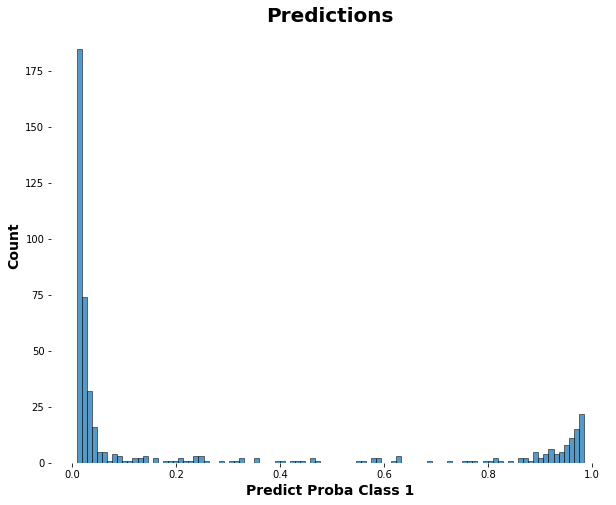

In [201]:
# histogram of class_1

plt.figure(figsize = (10, 8))
plt.title('Predictions', fontdict = font_dict_header)
sns.histplot(y_pred, bins = 100, kde = False)
plt.box(False)
plt.xlabel('Predict Proba Class 1', fontdict = font_dict_axistitle)
plt.ylabel('Count', fontdict = font_dict_axistitle)
plt.box(False)
plt.show()

In [200]:
X_train[y_pred_filter != y_true].sort_values(by = 'Class_1', ascending = False)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Gamma_1,Gamma_2,Gamma_3,Gamma_4,Gamma_5,Gamma_6,Gamma_7,Class_0,Class_1,Class True
223,1.366348,0.215393,-0.269977,0.161265,-0.218848,-0.019503,-0.081263,-1.699753,-0.031249,-0.570997,...,0.003848,0.009832,0.008957,0.023073,0.692566,0.165213,0.094254,0.039213,0.960787,0
83,-0.025461,0.646299,-0.269977,0.271614,0.105703,-0.323734,-0.081263,0.492752,-0.110995,-0.517184,...,0.028355,0.081572,0.026443,0.025098,0.372832,0.433164,0.016061,0.057962,0.942038,0
274,7.375293,1.456133,-0.269977,7.575668,5.375512,0.551775,-0.081263,1.944486,-0.064946,-0.048582,...,0.016975,0.010475,0.023050,0.015140,0.722701,0.144329,0.038090,0.106641,0.893359,0
429,-0.417167,-0.895805,0.260625,-0.299969,-0.218848,0.436844,-0.063292,0.251293,-0.052073,0.138254,...,0.007294,0.014439,0.009960,0.041261,0.208131,0.657841,0.056648,0.107978,0.892022,0
214,-0.300489,-0.874109,-0.269977,-0.135442,-0.218848,-0.012742,-0.081263,1.319972,0.013380,1.250454,...,0.006751,0.007964,0.007262,0.103658,0.334310,0.232220,0.303003,0.195976,0.804024,0
158,0.066215,0.110532,-0.269977,-0.207428,-0.218848,-0.070208,-0.081263,1.009951,-0.053161,-0.170546,...,0.004412,0.009566,0.011380,0.223634,0.163715,0.478912,0.103821,0.207442,0.792558,0
354,-0.808874,-0.938208,-0.269977,-0.439479,-0.218848,-0.949098,-0.081263,-0.885202,-0.097175,-0.315750,...,0.025407,0.013532,0.027750,0.011426,0.121546,0.742342,0.045587,0.225079,0.774921,0
402,0.466256,1.046601,0.368225,0.250062,-0.218848,-0.104012,-0.081263,1.331896,-0.110995,-0.657289,...,0.000994,0.001729,0.002846,0.023018,0.460280,0.070127,0.437892,0.236150,0.763850,0
173,-0.267152,-0.290311,0.151717,-0.234596,-0.194235,0.866148,0.007307,0.222974,-0.076825,0.771291,...,0.003928,0.005349,0.003170,0.028069,0.187145,0.686955,0.083637,0.242889,0.757111,0
278,-0.433836,2.111286,-0.269977,0.127881,0.300033,0.646425,-0.047247,-0.121328,-0.110995,-0.172131,...,0.019510,0.018423,0.013589,0.018680,0.134037,0.765768,0.020475,0.309874,0.690126,0


In [165]:
optimal_thresholds.groupby(['Max', 'Min']).mean().sort_values('Log Loss', ascending = True).head(10)

Log Loss
Max  Min           
0.99 0.02  0.210923
     0.01  0.210923
     0.00  0.210923
1.00 0.02  0.211928
     0.00  0.211928
     0.01  0.211928
0.98 0.02  0.250503
     0.01  0.250503
     0.00  0.250503
0.96 0.01  0.289752

In [139]:


parameters = {
    'weights': [
        [1, 1, 1, 1, 1],
        [1, 2, 2, 1, 1],
        [1, 2, 2, 1, 2],
        [3, 3, 2, 2, 2]
    ]
}

grid_obj = GridSearchCV(alpha_voting_classifier, parameters, scoring = balanced_log_loss_scorer, cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
alpha_voting_classifier = grid_obj.best_estimator_
alpha_voting_classifier.fit(X_train, y_train_class)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Tr

VotingClassifier(estimators=[('tabpfn24',
                              TabPFNClassifier(N_ensemble_configurations=24,
                                               seed=101010)),
                             ('tabpfn128',
                              TabPFNClassifier(N_ensemble_configurations=128,
                                               seed=101010)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x2ee6ea160>),
                             ('xtree',
                              ExtraTreesClassifier(criterion='log_loss',
                                                   max_depth=9,
                                                   max_features=0.5,
                                                   min_samples_split=3,
                                                   n_estima...
                                            interaction_constraints=None,
                                            learning_rate=0.02, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=150, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=101010,
                                            reg_alpha=None, reg_lambda=None, ...))],
                 voting='soft', weights=[1, 2, 2, 1, 1])

In [140]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.742723,0.052200,9.125715,0.130979,"[1, 2, 2, 1, 1]","{'weights': [1, 2, 2, 1, 1]}",-0.256125,-0.261528,-0.216527,-0.244727,0.020062,1
2,0.729505,0.019219,9.142061,0.107044,"[1, 2, 2, 1, 2]","{'weights': [1, 2, 2, 1, 2]}",-0.264303,-0.257397,-0.214064,-0.245255,0.022235,2
0,0.830699,0.044380,9.545078,0.092329,"[1, 1, 1, 1, 1]","{'weights': [1, 1, 1, 1, 1]}",-0.263803,-0.261149,-0.217812,-0.247588,0.021083,3
3,0.739267,0.035688,9.222489,0.161140,"[3, 3, 2, 2, 2]","{'weights': [3, 3, 2, 2, 2]}",-0.262784,-0.265446,-0.221663,-0.249965,0.020041,4


In [125]:
knn = KNeighborsClassifier(n_neighbors = 13, weights = 'distance', p = 1)
svm = SVC(C = 3, gamma = 'auto', kernel = 'rbf', probability = True, random_state = random_seed)
tabpfn = TabPFNClassifier(N_ensemble_configurations = 24, seed = random_seed)
histboost = HistGradientBoostingClassifier(max_iter = 50, learning_rate = 0.07, min_samples_leaf = 20, random_state = random_seed)
xgb = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 150, learning_rate = 0.02, max_depth = 3, gamma = 0.1, subsample = 0.7, random_state = random_seed)
xtree = ExtraTreesClassifier(criterion = 'log_loss', n_estimators = 250, max_depth = 9, min_samples_split = 3, max_features = 0.5, random_state = random_seed)
catboost = CatBoostClassifier(depth = 6, iterations = 100, learning_rate = 0.05, loss_function = 'Logloss', auto_class_weights = 'Balanced', verbose = False, random_seed = random_seed)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [102]:
meta_prediction_features_df

NameError: name 'meta_prediction_features_df' is not defined

In [134]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_class)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_class[train_index], y_train_class[test_index]
    
    
    model_features = X_train.columns.to_list()
    # KNN
    knn_features = ['Beta_0', 'Beta_1', 'Beta_3', 'Gamma_0', 'Gamma_1', 'Gamma_5', 'DU', 'FL', 'AY', 'EJ', 'DL', 'Days Since 1-1-2019']
    fold_scaled, oof_scaled = scale_and_impute(fold[knn_features], oof[knn_features])
    
    knn_predictions = fit_model('KNN 7', knn, fold_scaled, fold_y, oof_scaled, knn_features)
    
    svm_predictions = fit_model('SVM', svm, fold, fold_y, oof, model_features)
    tabpfn_predictions = fit_model('TabPFN', tabpfn, fold, fold_y, oof, model_features)
    histboost_predictions = fit_model('HistBoost', histboost, fold, fold_y, oof, model_features)
    xgb_predictions = fit_model('XGB', xgb, fold, fold_y, oof, model_features)
    xtree_predictions = fit_model('Xtree', xtree, fold, fold_y, oof, model_features)
    catboost_predictions = fit_model('CatBoost', catboost, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([
        tabpfn_predictions, histboost_predictions,
        xgb_predictions, catboost_predictions
    ], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])

In [135]:
# keep _1 columns 
model_prediction_features_df = model_prediction_features_df[[col for col in model_prediction_features_df.columns if '_1' in col]]


In [136]:
model_prediction_features_df.corr().mean().sort_values(ascending = False)

XGB_1          0.987917
CatBoost_1     0.983311
HistBoost_1    0.982724
TabPFN_1       0.981748
dtype: float64

In [75]:
knn_features = ['Beta_0', 'Beta_1', 'Beta_3', 'Gamma_0', 'Gamma_1', 'Gamma_5', 'DU', 'FL', 'AY', 'EJ', 'DL', 'Days Since 1-1-2019']

In [15]:
correlations_with_class = train_df[train_df.select_dtypes(include = ['int64', 'float64']).columns].corr()['Class'].sort_values(ascending = False)
correlations_with_class.drop('Class', inplace = True)
correlations_with_class = pd.DataFrame(correlations_with_class).reset_index().rename(columns = {'index': 'Column', 'Class': 'Correlation with Class'})
log_reg_cols = correlations_with_class[
    (correlations_with_class['Correlation with Class'] > 0.15) |
    (correlations_with_class['Correlation with Class'] < -.15)
]['Column'].to_list()
log_reg_cols.remove('Epsilon')

In [16]:
log_reg_cols = correlations_with_class[
    (correlations_with_class['Correlation with Class'] > 0.15) |
    (correlations_with_class['Correlation with Class'] < -.15)
]['Column'].to_list()
log_reg_cols.remove('Epsilon')

In [29]:
log_reg = LogisticRegression()
from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer

parameters = {
    'C': [7],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

x = X_train[log_reg_cols]
x = StandardScaler().fit_transform(x)
x = PowerTransformer().fit_transform(x)

grid_obj = GridSearchCV(log_reg, parameters, scoring = 'roc_auc', cv = 5)
grid_obj = grid_obj.fit(x, y_train_class)
log_reg = grid_obj.best_estimator_
log_reg.fit(x, y_train_class)

LogisticRegression(C=7, class_weight='balanced', solver='liblinear')

In [37]:
guassian = GaussianProcessClassifier()
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared

parameters = {
    'kernel': [1.0 * RBF(1.0)],
    'optimizer': ['fmin_l_bfgs_b'],
    'n_restarts_optimizer': [0],
    'max_iter_predict': [500]
}

x = X_train.copy()
x = StandardScaler().fit_transform(x)
x = PowerTransformer().fit_transform(x)
x = Normalizer().fit_transform(x)

grid_obj = GridSearchCV(guassian, parameters, scoring = 'roc_auc', cv = 3)
grid_obj = grid_obj.fit(x, y_train_class)
guassian = grid_obj.best_estimator_
guassian.fit(x, y_train_class)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1),
                          max_iter_predict=500)

In [38]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_max_iter_predict,param_n_restarts_optimizer,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.817341,0.291960,0.013575,0.000526,1**2 * RBF(length_scale=1),500,0,fmin_l_bfgs_b,"{'kernel': 1**2 * RBF(length_scale=1), 'max_it...",0.971084,0.937158,0.903352,0.937198,0.027652,1
2,1.465372,0.190341,0.012732,0.001178,"1**2 * RationalQuadratic(alpha=1, length_scale=1)",500,0,fmin_l_bfgs_b,"{'kernel': 1**2 * RationalQuadratic(alpha=1, l...",0.971084,0.937158,0.903352,0.937198,0.027652,1
1,0.564376,0.037252,0.011736,0.001439,"1**2 * Matern(length_scale=1, nu=1.5)",500,0,fmin_l_bfgs_b,"{'kernel': 1**2 * Matern(length_scale=1, nu=1....",0.969262,0.933060,0.899679,0.934000,0.028415,3
3,0.117878,0.070830,0.000000,0.000000,"1**2 * ExpSineSquared(length_scale=1, periodic...",500,0,fmin_l_bfgs_b,{'kernel': 1**2 * ExpSineSquared(length_scale=...,NaN,NaN,NaN,NaN,NaN,4


In [100]:
xgb = XGBClassifier(random_state = random_seed)

parameters = {
    'booster': ['gbtree'],
    'tree_method': ['auto', 'hist'],
    'n_estimators': [50, ],
    'max_depth': [2, 3, 4, 5, 6],
    'gamma': [0, 0.2, 0.4],
}

grid_obj = GridSearchCV(xgb, parameters, scoring = 'roc_auc', cv = 5)
grid_obj = grid_obj.fit(X_train_meta, y_train_class)
xgb = grid_obj.best_estimator_
xgb.fit(X_train_meta, y_train_class)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=101010, reg_alpha=0, reg_lambda=1, ...)

In [101]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_gamma,param_max_depth,param_n_estimators,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,0.070100,0.006180,0.002423,0.000058,gbtree,0,5,100,auto,"{'booster': 'gbtree', 'gamma': 0, 'max_depth':...",0.983188,0.983188,0.941469,0.995434,0.972603,0.975176,0.018339,1
20,0.033244,0.006319,0.002400,0.000083,gbtree,0,5,25,auto,"{'booster': 'gbtree', 'gamma': 0, 'max_depth':...",0.985056,0.983811,0.940224,0.995434,0.966080,0.974121,0.019398,2
22,0.108979,0.006072,0.002550,0.000167,gbtree,0,5,250,auto,"{'booster': 'gbtree', 'gamma': 0, 'max_depth':...",0.980697,0.980697,0.936488,0.996086,0.969993,0.972793,0.019967,3
23,0.181189,0.017215,0.002444,0.000042,gbtree,0,5,500,auto,"{'booster': 'gbtree', 'gamma': 0, 'max_depth':...",0.980697,0.980697,0.936488,0.996086,0.969993,0.972793,0.019967,3
53,0.227442,0.038893,0.002423,0.000049,gbtree,0.2,5,500,auto,"{'booster': 'gbtree', 'gamma': 0.2, 'max_depth...",0.976339,0.975093,0.951432,0.994129,0.964775,0.972354,0.014090,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,0.009707,0.000577,0.002332,0.000106,gbtree,0,5,5,auto,"{'booster': 'gbtree', 'gamma': 0, 'max_depth':...",0.958904,0.959215,0.919054,0.975864,0.966080,0.955823,0.019390,86
54,0.007295,0.000436,0.002024,0.000091,gbtree,0.2,6,5,auto,"{'booster': 'gbtree', 'gamma': 0.2, 'max_depth...",0.955479,0.962017,0.921544,0.975864,0.963144,0.955610,0.018268,87
42,0.007707,0.001954,0.002327,0.000099,gbtree,0.2,4,5,auto,"{'booster': 'gbtree', 'gamma': 0.2, 'max_depth...",0.959838,0.957347,0.919676,0.977495,0.963470,0.955565,0.019250,88
48,0.007395,0.000587,0.002230,0.000126,gbtree,0.2,5,5,auto,"{'booster': 'gbtree', 'gamma': 0.2, 'max_depth...",0.957659,0.960772,0.919054,0.975864,0.963470,0.955364,0.019178,89


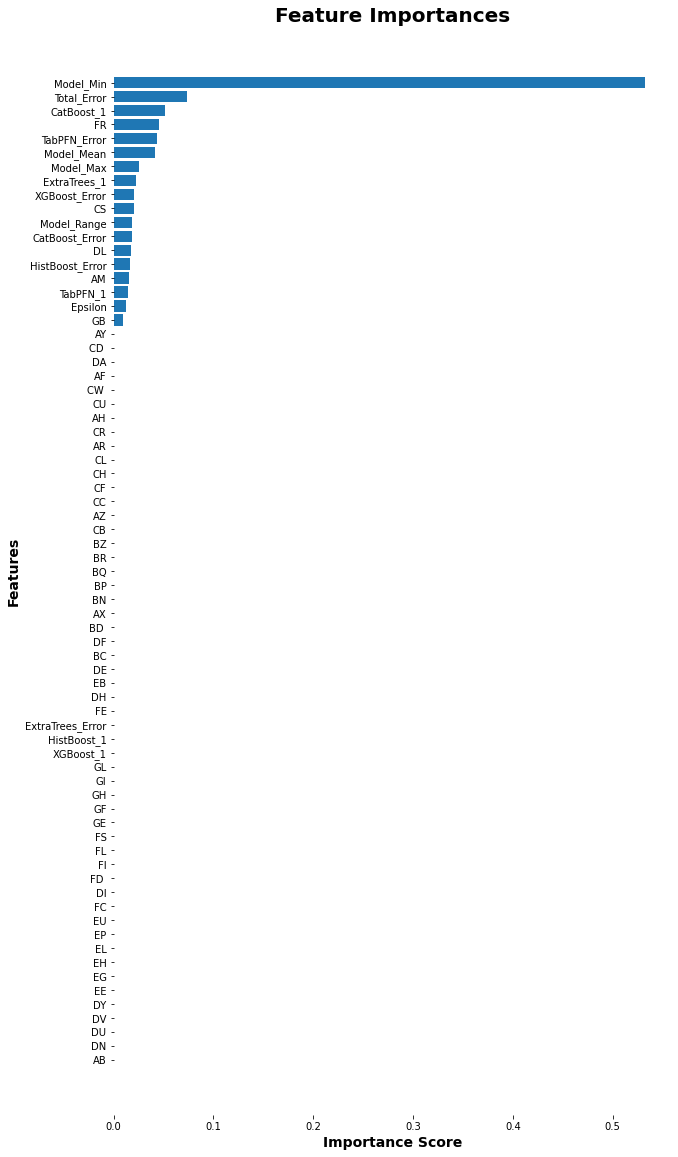

In [318]:
# plot feature importances
importances = pd.Series(xgb.feature_importances_, index = X_train_meta.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

In [587]:
xtree = ExtraTreesClassifier(random_state = random_seed)

parameters = {
    'criterion': ['log_loss'],
    'n_estimators': [250]
}

grid_obj = GridSearchCV(xtree, parameters, scoring = 'roc_auc', cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
xtree = grid_obj.best_estimator_
xtree.fit(X_train, y_train_class)

ExtraTreesClassifier(criterion='log_loss', n_estimators=250,
                     random_state=101010)

In [588]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.169128,0.005886,0.011801,0.000227,log_loss,250,"{'criterion': 'log_loss', 'n_estimators': 250}",0.598588,0.535178,0.550046,0.561271,0.027077,1


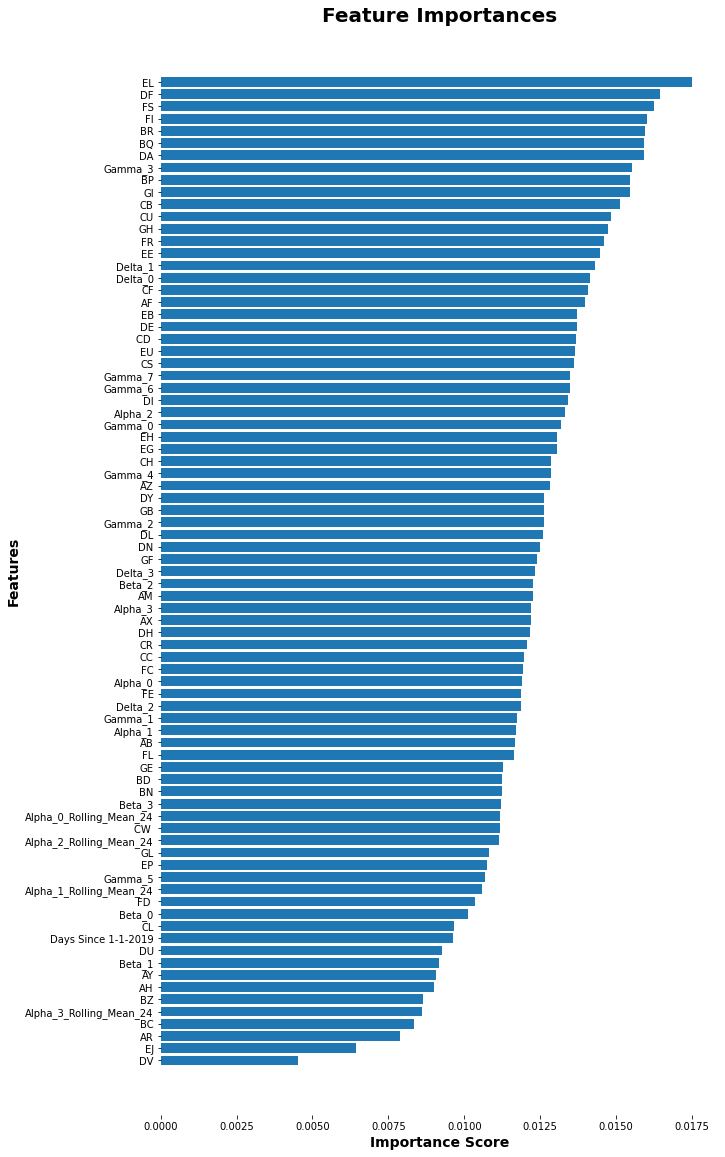

In [581]:
# plot feature importances
importances = pd.Series(xtree.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

In [370]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Initialize DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = random_seed)

# Define the parameter grid
parameters = {
    'criterion': ['gini'],
    'splitter': ['random'],
    'max_depth': [None, 1, 2, 3, 6],
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': [None],
    'class_weight': ['balanced']
}

# Create a GridSearchCV object
grid_obj = GridSearchCV(dtc, parameters, scoring = balanced_log_loss_scorer, cv = 3)

# Fit the GridSearchCV object to the data
grid_obj = grid_obj.fit(X_train, y_train_class)

# Get the best estimator
dtc = grid_obj.best_estimator_

# Fit the best estimator to the data
dtc.fit(X_train, y_train_class)


DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                       min_samples_leaf=16, random_state=101010,
                       splitter='random')

In [371]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
148,0.001208,0.000027,0.000862,0.000013,balanced,gini,2,None,16,40,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.440767,-0.224232,-0.355251,-0.340083,0.089048,1
146,0.001243,0.000043,0.000860,0.000009,balanced,gini,2,None,16,20,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.440767,-0.224232,-0.355251,-0.340083,0.089048,1
144,0.001320,0.000074,0.000900,0.000047,balanced,gini,2,None,16,10,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.440767,-0.224232,-0.355251,-0.340083,0.089048,1
140,0.001224,0.000036,0.000859,0.000010,balanced,gini,2,None,16,2,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.440767,-0.224232,-0.355251,-0.340083,0.089048,1
142,0.001270,0.000043,0.000914,0.000038,balanced,gini,2,None,16,5,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.440767,-0.224232,-0.355251,-0.340083,0.089048,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,0.006554,0.000550,0.001110,0.000038,balanced,gini,None,None,2,5,best,"{'class_weight': 'balanced', 'criterion': 'gin...",-6.446114,-7.165320,-5.660568,-6.424001,0.614512,246
0,0.002420,0.000291,0.001174,0.000082,balanced,gini,None,None,1,2,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-6.833833,-8.980711,-4.785159,-6.866568,1.712983,247
2,0.002584,0.000537,0.001134,0.000049,balanced,gini,None,None,1,5,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-6.433321,-8.758703,-5.767371,-6.986465,1.282314,248
3,0.007201,0.000265,0.001428,0.000047,balanced,gini,None,None,1,5,best,"{'class_weight': 'balanced', 'criterion': 'gin...",-7.377855,-8.697606,-5.656977,-7.244146,1.244927,249


In [227]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
76,0.058259,0.007870,0.002018,0.000101,gbtree,0.1,0.03,2,100,0.5,hist,"{'booster': 'gbtree', 'gamma': 0.1, 'learning_...",-0.319818,-0.259985,-0.217141,-0.265648,0.042108,1
77,0.088427,0.008813,0.002050,0.000086,gbtree,0.1,0.03,2,150,0.5,hist,"{'booster': 'gbtree', 'gamma': 0.1, 'learning_...",-0.315756,-0.266867,-0.214327,-0.265650,0.041417,2
28,0.069268,0.017374,0.002102,0.000008,gbtree,0,0.03,2,100,0.5,hist,"{'booster': 'gbtree', 'gamma': 0, 'learning_ra...",-0.322464,-0.260131,-0.217458,-0.266684,0.043118,3
29,0.099064,0.018956,0.002650,0.000669,gbtree,0,0.03,2,150,0.5,hist,"{'booster': 'gbtree', 'gamma': 0, 'learning_ra...",-0.319872,-0.267767,-0.214575,-0.267405,0.042988,4
82,0.093323,0.002906,0.002124,0.000055,gbtree,0.1,0.03,6,100,0.5,hist,"{'booster': 'gbtree', 'gamma': 0.1, 'learning_...",-0.326936,-0.261513,-0.217699,-0.268716,0.044886,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,0.045793,0.002507,0.002350,0.000398,gbtree,0,0.02,3,50,0.5,hist,"{'booster': 'gbtree', 'gamma': 0, 'learning_ra...",-0.418125,-0.359916,-0.338335,-0.372125,0.033699,92
69,0.053513,0.002209,0.002117,0.000039,gbtree,0.1,0.02,6,50,0.5,hist,"{'booster': 'gbtree', 'gamma': 0.1, 'learning_...",-0.420191,-0.359787,-0.337230,-0.372403,0.035024,93
21,0.049523,0.003657,0.002008,0.000059,gbtree,0,0.02,6,50,0.5,hist,"{'booster': 'gbtree', 'gamma': 0, 'learning_ra...",-0.422454,-0.360236,-0.338235,-0.373642,0.035665,94
12,0.020355,0.001083,0.001947,0.000042,gbtree,0,0.02,1,50,0.5,hist,"{'booster': 'gbtree', 'gamma': 0, 'learning_ra...",-0.415990,-0.366650,-0.347668,-0.376769,0.028796,95


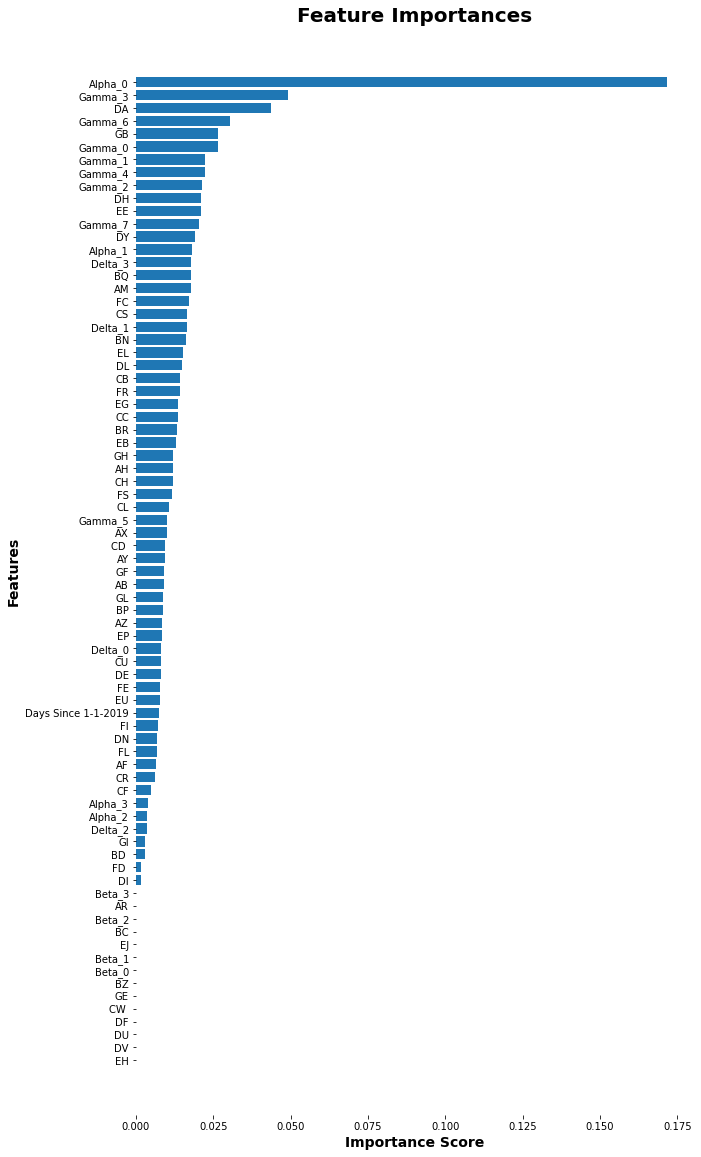

In [291]:
# plot feature importances
importances = pd.Series(xgb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

In [262]:
xtree = ExtraTreesClassifier(random_state = random_seed)

parameters = {
    'criterion': ['log_loss'],
    'n_estimators': [100],
    'max_depth': [9],
    'min_samples_split': [3],
    'max_features': ['sqrt']
}

grid_obj = GridSearchCV(xtree, parameters, scoring = balanced_log_loss_scorer, cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
xtree = grid_obj.best_estimator_
xtree.fit(X_train, y_train_class)

ExtraTreesClassifier(criterion='log_loss', max_depth=9, min_samples_split=3,
                     random_state=101010)

In [263]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.053239,0.007223,0.004611,0.000331,log_loss,9,sqrt,3,100,"{'criterion': 'log_loss', 'max_depth': 9, 'max...",-0.512572,-0.511582,-0.521375,-0.515176,0.004402,1


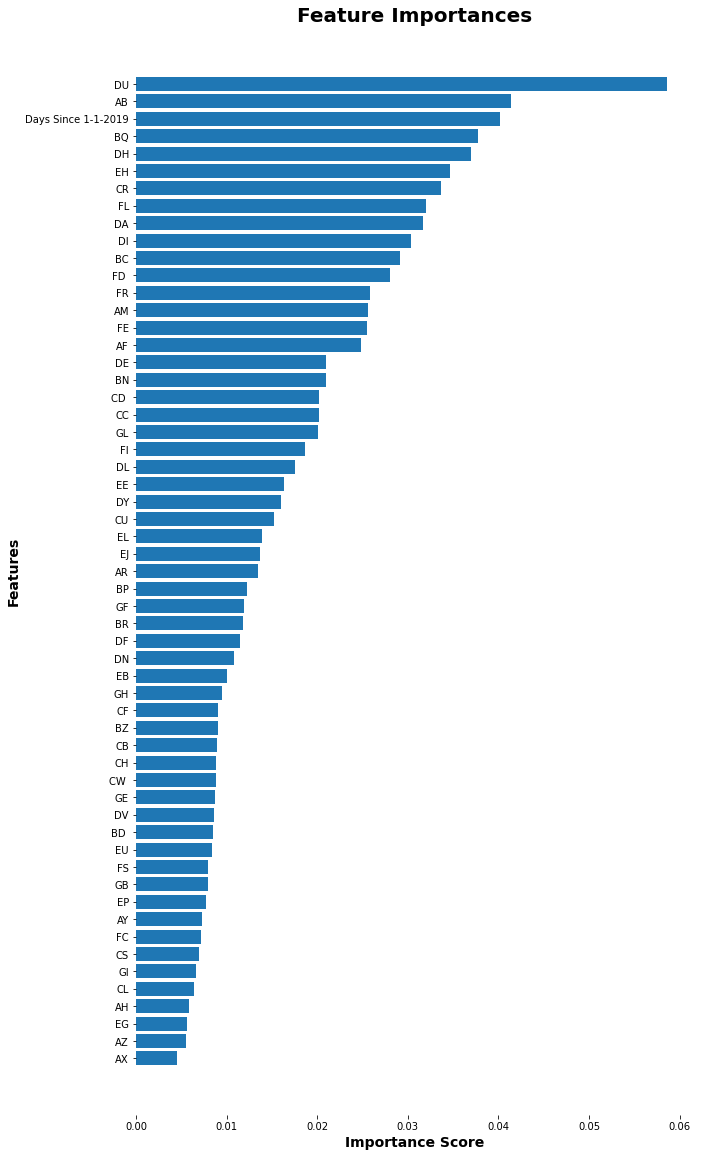

In [264]:
# plot feature importances
importances = pd.Series(xtree.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

In [584]:
tabpfn = TabPFNClassifier(seed = random_seed)

parameters = {
    'N_ensemble_configurations': [24]
}

grid_obj = GridSearchCV(tabpfn, parameters, scoring = 'roc_auc', cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
tabpfn = grid_obj.best_estimator_
tabpfn.fit(X_train, y_train_class)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


TabPFNClassifier(N_ensemble_configurations=24, seed=101010)

In [585]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_N_ensemble_configurations,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001338,0.000163,1.506042,0.011642,24,{'N_ensemble_configurations': 24},0.46653,0.560109,0.490588,0.505742,0.039678,1


In [246]:
from sklearn.svm import SVC
svm = SVC(random_state = random_seed)

parameters = {
    'C': [3],
    'gamma': ['auto'],
    'kernel': ['rbf'],
    'probability': [True],
}

grid_obj = GridSearchCV(svm, parameters, scoring = balanced_log_loss_scorer, cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
svm = grid_obj.best_estimator_

# Fit the best estimator to the data
svm.fit(X_train, y_train_class)


SVC(C=3, gamma='auto', probability=True, random_state=101010)

In [247]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_probability,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015398,0.000628,0.003647,0.000222,3,auto,rbf,True,"{'C': 3, 'gamma': 'auto', 'kernel': 'rbf', 'pr...",-0.33431,-0.339342,-0.308012,-0.327221,0.013737,1


In [254]:
histboost = HistGradientBoostingClassifier(random_state = random_seed)

parameters = {
    'max_iter': [100],
    'learning_rate': [0.1],
    'min_samples_leaf': [50]
    
}

grid_obj = GridSearchCV(histboost, parameters, scoring = balanced_log_loss_scorer, cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
histboost = grid_obj.best_estimator_
histboost.fit(X_train, y_train_class)

HistGradientBoostingClassifier(min_samples_leaf=50, random_state=101010)

In [255]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l2_regularization,param_learning_rate,param_max_iter,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.153582,0.035590,0.005300,0.001034,0.0,0.1,100,50,"{'l2_regularization': 0.0, 'learning_rate': 0....",-0.476798,-0.402011,-0.314081,-0.397630,0.066501,1
1,0.156537,0.010165,0.006353,0.000724,0.01,0.1,100,50,"{'l2_regularization': 0.01, 'learning_rate': 0...",-0.483337,-0.396238,-0.325590,-0.401722,0.064517,2
3,0.122843,0.007785,0.004439,0.000724,0.05,0.1,100,50,"{'l2_regularization': 0.05, 'learning_rate': 0...",-0.453775,-0.414446,-0.341397,-0.403206,0.046561,3
2,0.154522,0.042145,0.005921,0.001807,0.02,0.1,100,50,"{'l2_regularization': 0.02, 'learning_rate': 0...",-0.479132,-0.399333,-0.335385,-0.404617,0.058803,4


In [266]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Initialize CatBoostClassifier
catb = CatBoostClassifier(random_seed = random_seed, verbose=False)

# Define the parameter grid
parameters = {
    'depth': [3],
    'learning_rate': [0.05],
    'iterations': [250],
    'loss_function': ['Logloss'],
    'auto_class_weights': ['Balanced'],
}

# Create a GridSearchCV object
grid_obj = GridSearchCV(catb, parameters, scoring = balanced_log_loss_scorer, cv = 5)

# Fit the GridSearchCV object to the data
grid_obj = grid_obj.fit(X_train, y_train_class)

# Get the best estimator
catb = grid_obj.best_estimator_

# Fit the best estimator to the data
catb.fit(X_train, y_train_class)


In [265]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_auto_class_weights,param_depth,param_iterations,param_learning_rate,param_loss_function,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.176577,0.005187,0.002012,0.000109,Balanced,3,250,0.05,Logloss,"{'auto_class_weights': 'Balanced', 'depth': 3,...",-0.200840,-0.327442,-0.274566,-0.275046,-0.266327,-0.268844,0.040338,1
3,0.179056,0.008807,0.001994,0.000031,Balanced,3,250,0.07,Logloss,"{'auto_class_weights': 'Balanced', 'depth': 3,...",-0.220975,-0.339983,-0.288669,-0.281644,-0.245305,-0.275315,0.040629,2
1,0.181945,0.012121,0.001950,0.000054,Balanced,3,250,0.03,Logloss,"{'auto_class_weights': 'Balanced', 'depth': 3,...",-0.215737,-0.317876,-0.288498,-0.348992,-0.267131,-0.287647,0.045321,3
0,0.178650,0.004940,0.001982,0.000118,Balanced,3,250,0.02,Logloss,"{'auto_class_weights': 'Balanced', 'depth': 3,...",-0.257428,-0.350034,-0.306296,-0.329812,-0.276206,-0.303955,0.033859,4


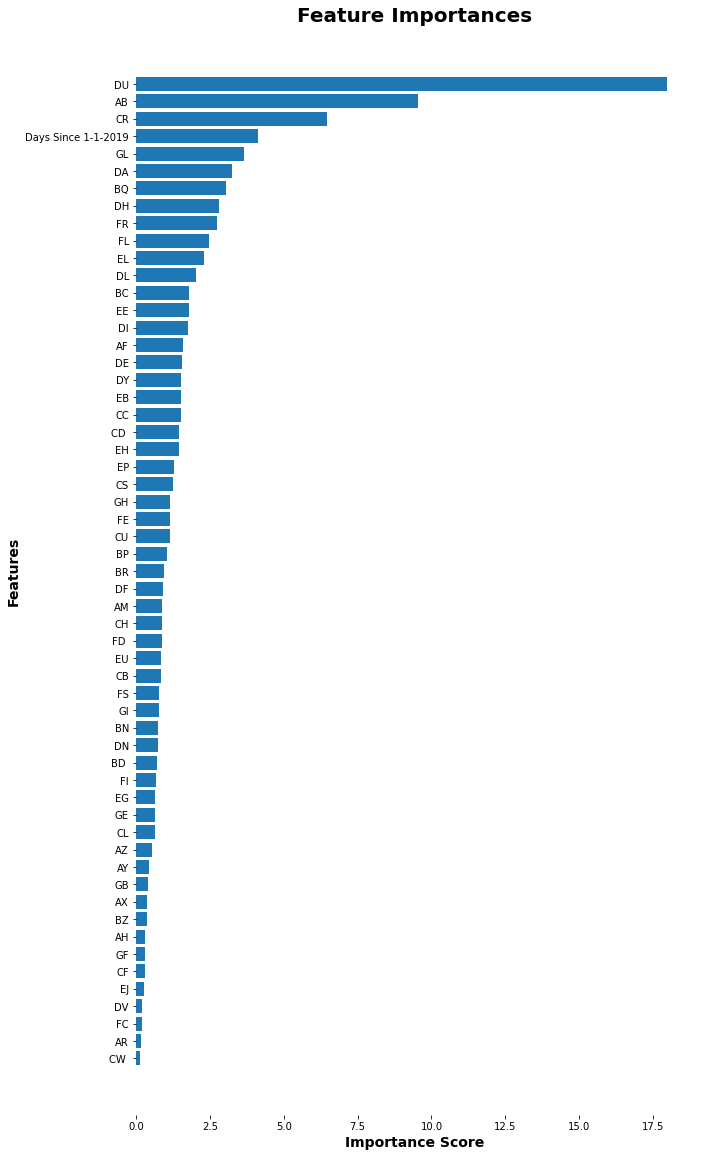

In [267]:
# plot feature importances
importances = pd.Series(catb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

# Alpha Prediction Features

### Model Prediction Features
KNN, Extra Trees, and TabPFN

In [145]:
def fit_model(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    model.fit(X, y)
    model_predictions = model.predict_proba(test)
    predictions_df = pd.DataFrame(model_predictions, columns = model.classes_, index=X_test.index)
    predictions_df.columns = [model_name + '_' + str(col) for col in predictions_df.columns]
    
    return predictions_df

In [146]:
greek_prediction_cols = X_train.columns.to_list()

In [147]:
# alpha models
knn = KNeighborsClassifier(n_neighbors = 7)
svm = SVC(probability = True, random_state = random_seed)
extra_trees = ExtraTreesClassifier(n_estimators = 250, random_state = random_seed)
tabpfn = TabPFNClassifier(N_ensemble_configurations = 64, seed = random_seed)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [148]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_alpha[train_index], y_train_alpha[test_index]
    
    model_features = [
        'DU', 'CR', 'AB', 'DA', 'DH', 'BC', 'FR', 'EP', 'DI', 'FL', 'EU', 'EH', 'Days Since 1-1-2019'
    ]
    
    # fit models
    knn_features = model_features[0:3]
    knn_features.append(model_features[-1])
    
    knn_predictions = fit_model('KNN 7 Alpha', knn, fold, fold_y, oof, knn_features)
    svm_predictions = fit_model('SVM Alpha', svm, fold, fold_y, oof, model_features)
    extra_trees_predictions = fit_model('Extra Trees Alpha', extra_trees, fold, fold_y, oof, model_features)
    tabpfn_predictions = fit_model('TabPFN Alpha', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([knn_predictions, svm_predictions, extra_trees_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])
    
X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)
for pred_class in y_train_alpha:
    X_train['Alpha_' + str(pred_class)] = X_train['Extra Trees Alpha_' + str(pred_class)] + X_train['TabPFN Alpha_' + str(pred_class)]

In [149]:
alpha_models = {
    'KNN 7': knn.fit(X_train[knn_features], y_train_alpha),
    'SVM': svm.fit(X_train[model_features], y_train_alpha),
    'Extra Trees': extra_trees.fit(X_train[model_features], y_train_alpha),
    'TabPFN': tabpfn.fit(X_train[model_features], y_train_alpha)
}

In [150]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_beta)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_beta[train_index], y_train_beta[test_index]
    
    model_features = greek_prediction_cols.copy()
    
    # fit models
    extra_trees_predictions = fit_model('Extra Trees Beta', extra_trees, fold, fold_y, oof, model_features)
    tabpfn_predictions = fit_model('TabPFN Beta', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([extra_trees_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])
    
X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)
for pred_class in y_train_beta:
    X_train['Beta_' + str(pred_class)] = X_train['Extra Trees Beta_' + str(pred_class)] + X_train['TabPFN Beta_' + str(pred_class)]

In [151]:
beta_models = {
    'Extra Trees': extra_trees.fit(X_train[model_features], y_train_beta),
    'TabPFN': tabpfn.fit(X_train[model_features], y_train_beta)
}

In [152]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_delta)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_delta[train_index], y_train_delta[test_index]
    
    model_features = greek_prediction_cols.copy()
    
    # fit models
    extra_trees_predictions = fit_model('Extra Trees Delta', extra_trees, fold, fold_y, oof, model_features)
    tabpfn_predictions = fit_model('TabPFN Delta', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([extra_trees_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])
    
X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)
for pred_class in y_train_delta:
    X_train['Delta_' + str(pred_class)] = X_train['Extra Trees Delta_' + str(pred_class)] + X_train['TabPFN Delta_' + str(pred_class)]
    
X_train.drop([
    'Extra Trees Delta_0', 'Extra Trees Delta_1', 'Extra Trees Delta_2', 'Extra Trees Delta_3', 
    'TabPFN Delta_0', 'TabPFN Delta_1', 'TabPFN Delta_2', 'TabPFN Delta_3'
], axis = 1, inplace = True)

In [153]:
delta_models = {
    'Extra Trees': extra_trees.fit(X_train[model_features], y_train_delta),
    'TabPFN': tabpfn.fit(X_train[model_features], y_train_delta)
}

In [154]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_gamma)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_gamma[train_index], y_train_gamma[test_index]
    
    model_features = greek_prediction_cols.copy()
    
    # fit models
    extra_trees_predictions = fit_model('Extra Trees Gamma', extra_trees, fold, fold_y, oof, model_features)
    tabpfn_predictions = fit_model('TabPFN Gamma', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([extra_trees_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])
    
X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)
for pred_class in y_train_gamma:
    X_train['Gamma_' + str(pred_class)] = X_train['Extra Trees Gamma_' + str(pred_class)] + X_train['TabPFN Gamma_' + str(pred_class)]
    
X_train.drop([
    'Extra Trees Gamma_0', 'Extra Trees Gamma_1', 'Extra Trees Gamma_2', 'Extra Trees Gamma_3', 'Extra Trees Gamma_4', 'Extra Trees Gamma_5', 'Extra Trees Gamma_6', 'Extra Trees Gamma_7',
    'TabPFN Gamma_0', 'TabPFN Gamma_1', 'TabPFN Gamma_2', 'TabPFN Gamma_3', 'TabPFN Gamma_4', 'TabPFN Gamma_5', 'TabPFN Gamma_6', 'TabPFN Gamma_7'
], axis = 1, inplace = True)

In [155]:
gamma_models = {
    'Extra Trees': extra_trees.fit(X_train[model_features], y_train_gamma),
    'TabPFN': tabpfn.fit(X_train[model_features], y_train_gamma)
}

In [156]:
print('Shape of X:', X_train.shape)
print('Shape of y:', y_train_alpha.shape)

Shape of X: (473, 101)
Shape of y: (473,)


In [157]:
# print('Shape of X:', X_test.shape)
# print('Shape of y:', y_test.shape)

# Model Pipeline

In [158]:
def competition_log_loss(y_true, y_pred):
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = np.clip(1 - proba_1, 1e-15, 1 - 1e-15)
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

In [159]:
X_train['Class'] = y_train_class
X_train['Alpha'] = y_train_alpha

In [160]:
# models
xgb = XGBClassifier(
    booster = 'gbtree',
    learning_rate = 0.02,
    n_estimators = 300,
    max_depth = 6,
    gamma = 0.3,
    min_child_weight = 2,
    max_delta_step = 1,
    subsample = 0.7,
    base_score = 0.85,
    n_jobs = -1, random_state = random_seed
)

catboost = CatBoostClassifier(
    iterations = 500,
    learning_rate = 0.05,
    depth = 7,
    loss_function = 'MultiClass',
    eval_metric = 'AUC',
    random_seed = random_seed,
    verbose = False,
)

tabpfn = TabPFNClassifier(
    N_ensemble_configurations = 64
)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [161]:
X_train.columns[: -68]

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY'],
      dtype='object')

In [162]:
y_true = []
y_pred = []
log_loss = []

skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y_class, oof_y_class = y_train_class[train_index], y_train_class[test_index]
    fold_y_alpha, oof_y_alpha = y_train_alpha[train_index], y_train_alpha[test_index]
    
    # over sample
    over_sampler = RandomOverSampler(random_state = random_seed)
    fold, fold_y_class = over_sampler.fit_resample(fold, fold_y_class)
    fold_y_alpha = fold['Alpha']
    fold.drop(['Alpha', 'Class'], axis = 1, inplace = True)
    oof.drop(['Alpha', 'Class'], axis = 1, inplace = True)
    
    # train models
    non_alpha_cols = [col for col in X_train.columns if 'Alpha' not in col]
    non_alpha_cols.remove('Class')
    
    xgb.fit(fold, fold_y_alpha)
    tabpfn.fit(fold[non_alpha_cols], fold_y_alpha)
    
    # predict oof
    oof_y_alpha_proba = xgb.predict_proba(oof)
    oof_y_alpha_proba += tabpfn.predict_proba(oof[non_alpha_cols])
    oof_y_alpha_proba /= 2
    
    class_0 = oof_y_alpha_proba[:, 0].sum()
    class_123 = oof_y_alpha_proba[:, 1:].sum()
    new_probabilities = oof_y_alpha_proba * np.array([[1/(class_0 if i == 0 else class_123) for i in range(oof_y_alpha_proba.shape[1])]])
    oof_y_alpha_proba =  new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
    
    oof_y_class_proba = oof_y_alpha_proba[:, 1:].sum(axis = 1)
    # oof_y_class_proba[oof_y_class_proba > 0.95] = 1
    # oof_y_class_proba[oof_y_class_proba < 0.025] = 0
    
    fold_log_loss = competition_log_loss(oof_y_class, oof_y_class_proba)
    log_loss.append(fold_log_loss)
    
    print('Balanced Log Loss:', fold_log_loss)
    y_true.append(oof_y_class)
    y_pred.append(oof_y_class_proba)

81
Balanced Log Loss: 0.12314293729268876
81
Balanced Log Loss: 0.24797380812598277
81
Balanced Log Loss: 0.16025999144270348
81
Balanced Log Loss: 0.27208488957378996
81
Balanced Log Loss: 0.10073736062200327


In [163]:
np.mean(log_loss)

0.18083979741143363

In [164]:
max_pred = [
    0.75, 0.76, 0.77, 0.78, 0.79, 
    0.80, 0.81, 0.82, 0.83, 0.84, 
    0.85, 0.86, 0.87, 0.88, 0.89, 
    0.90, 0.91, 0.92, 0.93, 0.94, 
    0.95, 0.96, 0.97, 0.98, 0.99,
    1.00
]
min_pred = [
    0.00, 0.01, 0.02, 0.03, 0.04, 
    0.05, 0.06, 0.07, 0.08, 0.09, 
    0.10, 0.11, 0.12, 0.13, 0.14, 
    0.15, 0.16, 0.17, 0.18, 0.19, 
    0.20, 0.21, 0.22, 0.23, 0.24, 
    0.25
]

optimal_thresholds = pd.DataFrame({}, columns = ['Max', 'Min', 'Log Loss'])
for max_v in max_pred:
    for min_v in min_pred:
        for i in range(len(y_pred)):
            fold_pred = y_pred[i].copy()
            fold_true = y_true[i].copy()
            
            fold_pred[fold_pred > max_v] = 1
            fold_pred[fold_pred < min_v] = 0
            
            loss = competition_log_loss(fold_true, fold_pred)
            
            # add to dataframe
            new_row = pd.DataFrame({'Max': [max_v], 'Min': [min_v], 'Log Loss': [loss]})
            optimal_thresholds = pd.concat([optimal_thresholds, new_row], ignore_index = True)

In [165]:
optimal_thresholds.groupby(['Max', 'Min']).mean().sort_values('Log Loss', ascending = True).head(10)

Log Loss
Max  Min           
0.98 0.01  0.179543
     0.00  0.179596
0.99 0.01  0.180017
     0.00  0.180070
1.00 0.01  0.180787
     0.00  0.180840
0.93 0.01  0.260345
     0.00  0.260397
0.94 0.01  0.261577
     0.00  0.261630

In [169]:
X_train.drop(['Class', 'Alpha'], axis = 1, inplace = True)

In [170]:
xgb = XGBClassifier(
    booster = 'gbtree',
    learning_rate = 0.02,
    n_estimators = 300,
    max_depth = 6,
    gamma = 0.3,
    min_child_weight = 2,
    max_delta_step = 1,
    subsample = 0.7,
    base_score = 0.85,
    n_jobs = -1, random_state = random_seed
)

In [171]:
xgb.fit(X_train, y_train_class)

XGBClassifier(base_score=0.85, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=101010, reg_alpha=0, reg_lambda=1, ...)

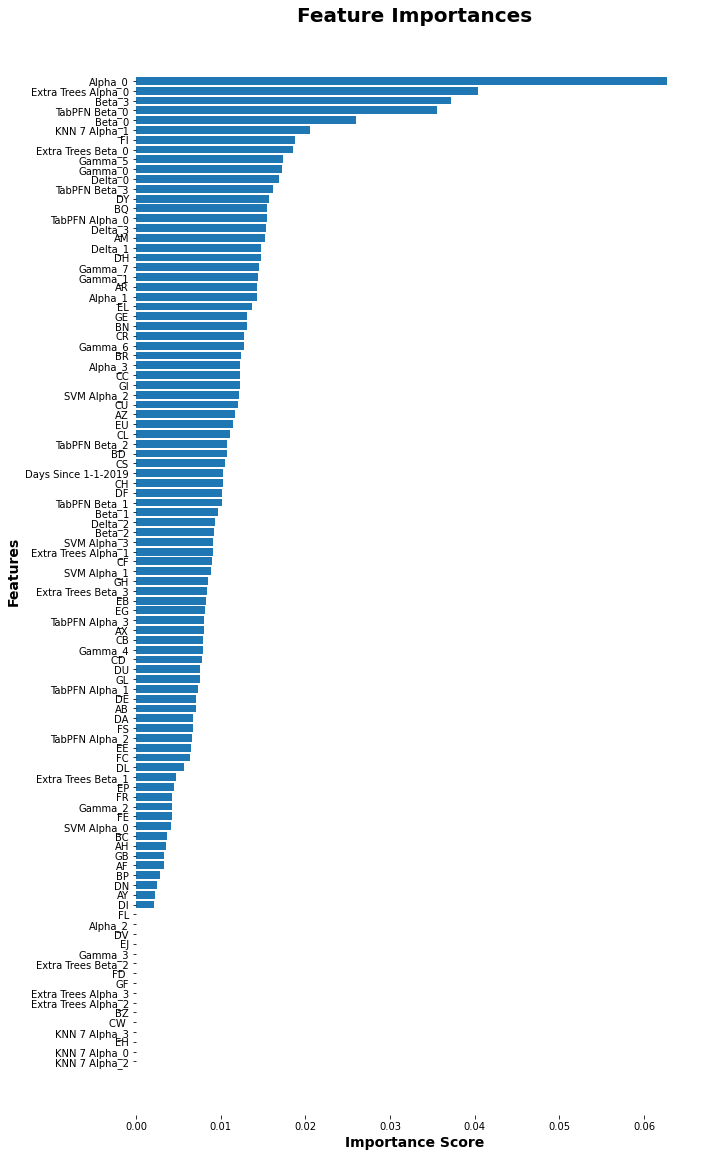

In [172]:
importances = pd.Series(xgb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()